### **$\color{red}{\text{ОТВЕТ НА КОММЕНТАРИЙ}}$**

У меня не получается сделать график-воронку, т.к. при запуске этого кода появляется ошибка с невозможностью выполнить скрипт.

# Описание задачи:
Фонд «АиФ. Доброе сердце» был создан в 2005-м году по инициативе еженедельной газеты «Аргументы и факты». За эти годы больше 10 тысяч подопечных со сложными диагнозами получили помощь с оплатой операций, лекарств и медоборудования.

## Описание проекта:
Благотворительный фонд АиФ Доброе сердце хочет лучше узнать своих благотворителей, чтобы максимально эффективно выстроить работу с ними.
По итогам проекта представители фонда хотели бы получить следующие результаты:
Сегменты пользователей: RFM-анализ, описание сегментов, таблицу с id благотворителя и его сегментом;
Когортный анализ: заказчик просит разбить когорты по месяцам;
Прочие метрики, которые можно получить из данных.
Для анализа представлены следующие данные:
данные о действиях пользователей (3 файла);
данные о платежах пользователей (1 файл).


## Задачи:

– анализ эффективности каналов привлечения пользователей.
– проведение RFM-анализа,
– проведение когортного анализа (retention, LTV, средний чек),
– расчет основных маркетинговых и продуктовых метрик.





# Реализация проекта

## Исследовательский анализ

Загружаем необходимые библиотеки

In [ ]:
pip install squarify

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from operator import attrgetter
from datetime import date,timedelta
import squarify

In [ ]:
# для отражение чисел с 2 знаками после запятой
pd.set_option('display.float_format', lambda x: f'{x:.2f}')

### Анализ файла с действиями

Создаем списки для файлов и датасетов

In [ ]:
list_of_files = ['dobroaif_1.csv', 'dobroaif_2.csv', 'dobroaif_3.csv']

In [ ]:
list_of_dfs = []

Делаем списки с названием колонок

In [ ]:
new_cols = ['action_id', 'user_action', 'datetime', 'channel_id', 'channel_name', 'user_id', 'status_sending', 'name_action_mail', 'id_action_mailing']

Загружаем датасеты

In [ ]:
for file in list_of_files:
  df = pd.read_csv(file, encoding='utf8', sep=';', usecols=[0, 2, 4, 6, 7, 17, 21, 22, 24])
  old_cols = df.columns.tolist()
  cols_dict = {k: v for k, v in zip(old_cols, new_cols)}
  df = df.rename(columns=cols_dict)
  list_of_dfs.append(df)

Соединяем датасеты

In [ ]:
total = pd.concat(list_of_dfs)

Загружаем датасет с платежами

In [ ]:
payments = pd.read_csv('paymentsaif.csv', sep=';',usecols=[0, 2, 3, 17, 20, 21, 30], encoding='cp1251')
payments.columns = ['order_id', 'order_datetime', 'channel_id', 'product_name', 'order_price', 'paid_status', 'user_id']
payments.order_datetime = pd.to_datetime(payments.order_datetime, dayfirst=True).dt.date.astype('datetime64[ns]')

Выводим датасет по действиям

In [ ]:
total.head()

action_id                                        user_action  \
0       2734     Импорт при переносе исторической базы клиентов   
1      80475                                      Оплата заказа   
2     101792                                      Оплата заказа   
3     632765  Изменение часового пояса клиентов при изменени...   
4     632766                                    Переход на сайт   

              datetime  channel_id                   channel_name  user_id  \
0  2022-03-19 21:30:59        9.00                           Сайт  2734.00   
1  2022-04-18 15:48:35        1.00  Административный сайт Mindbox  2734.00   
2  2022-04-18 15:49:50        1.00  Административный сайт Mindbox  2734.00   
3  2022-11-23 08:40:16        9.00                           Сайт  2734.00   
4  2022-11-23 08:40:16     1729.00             utm_term Не указан  2734.00   

  status_sending name_action_mail  id_action_mailing  
0            NaN              NaN                NaN  
1            NaN              NaN                NaN  
2            NaN              NaN                NaN  
3            NaN              NaN                NaN  
4            NaN              NaN                NaN

Изучим датасет на выбросы и статистический анализ

In [ ]:
total.shape

(526849, 9)

In [ ]:
total.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 526849 entries, 0 to 115607
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   action_id          526849 non-null  int64  
 1   user_action        526849 non-null  object 
 2   datetime           526848 non-null  object 
 3   channel_id         526848 non-null  float64
 4   channel_name       526848 non-null  object 
 5   user_id            526848 non-null  float64
 6   status_sending     434687 non-null  object 
 7   name_action_mail   434687 non-null  object 
 8   id_action_mailing  434687 non-null  float64
dtypes: float64(3), int64(1), object(5)
memory usage: 40.2+ MB


Посмотрим пропуски и дубликаты

In [ ]:
total.isna().sum() / len(total)

action_id           0.00
user_action         0.00
datetime            0.00
channel_id          0.00
channel_name        0.00
user_id             0.00
status_sending      0.17
name_action_mail    0.17
id_action_mailing   0.17
dtype: float64

In [ ]:
total.duplicated().sum()

0

Посмотрим распределение user_ation

In [ ]:
total['user_action'].nunique()

986

У нас 1138 вариантов действия пользователя. Посмотрим самые популярные.

In [ ]:
total['user_action'].value_counts().head(20)

Переход на сайт                                                                           11078
Просмотр “Дети”                                                                           10793
Оформление заказа в операции Заказ - Создание неавторизованным                             7810
RFM. Письмо 2                                                                              7521
RFM. Письмо 2 Отправка                                                                     7521
RFM. Письмо 1                                                                              7259
RFM. Письмо 1 Отправка                                                                     7259
RFM. Письмо 3                                                                              6891
RFM. Письмо 3 Отправка                                                                     6891
Счастливая история Марк Садартинов. Разовые                                                6586
Счастливая история Марк Садартинов. Разо

Посмотрим топ-10 действий по количеству уникальных пользователей в ней.

In [ ]:
total.groupby('user_action')['user_id'].nunique().sort_values(ascending=False).head(10)

user_action
Счастливая история Марк Садартинов. Разовые Отправка     6585
Счастливая история Марк Садартинов. Разовые              6585
Копия Фандрайзинговая. Герман Семенов Отправка           6553
Копия Фандрайзинговая. Герман Семенов                    6553
Копия Копия Фандрайзинговая. Даша Семенова 2 Отправка    5061
Копия Копия Фандрайзинговая. Даша Семенова 2             5061
Копия Копия Фандрайзинговая. Герман Семенов Отправка     4973
Копия Копия Фандрайзинговая. Герман Семенов              4973
RFM. Письмо 3 Отправка                                   4708
RFM. Письмо 3                                            4708
Name: user_id, dtype: int64

В идеале стоит спросить у заказчика чем отличаются действия друг от друга с одинаковыми названия, но со словом "Отправка".

In [ ]:
total['status_sending'].isna().sum()

92162

Скорее всего пропуски в статусе рассылки относятся к действиях не связанным с email-маркетингом. Посмотрим какие это действия и посмотрим топ-10

In [ ]:
total.query('status_sending.isna()')['user_action'].value_counts().head(10)

Переход на сайт                                                                           11078
Просмотр “Дети”                                                                           10793
Оформление заказа в операции Заказ - Создание неавторизованным                             7810
Изменение статуса заказа в операции Заказ - Смена статуса.                                 6374
Оплата заказа                                                                              5916
Просмотр продукта в операции 'Просмотр продукта'                                           5793
Добавление продукта в список в операции 'Добавление в список — Просмотренные продукты'     5791
Пожертвование — разово                                                                     5527
Email признан валидным                                                                     3950
Импорт при переносе исторической базы клиентов                                             3166
Name: user_action, dtype: int64

Посмотрим сколько вариантов каналов

In [ ]:
# распределение доли пользователей среди каналов
total['channel_name'].value_counts(normalize=True)


Email                                  0.83
Сайт                                   0.12
Административный сайт Mindbox          0.03
utm_term Не указан                     0.01
Прямой переход                         0.01
                                       ... 
xn--80afcdbalict6afooklqi5o.xn--p1ai   0.00
org.telegram.messenger                 0.00
google.de                              0.00
m.sport.yandex.ru                      0.00
{keyword}                              0.00
Name: channel_name, Length: 87, dtype: float64

Каналов 223, посмотрим сколько каналов, с количеством пользователей больше 200.

In [ ]:
total['channel_name'].value_counts().loc[lambda x : x > 200]

Email                            435271
Сайт                              64982
Административный сайт Mindbox     15423
utm_term Не указан                 5457
Прямой переход                     3096
google.com                          571
yandex.ru                           540
vk.com                              282
Name: channel_name, dtype: int64

Основных каналов у нас получается 23.

Посмотрим сколько у нас уникальных пользователей в базе.

In [ ]:
total['user_id'].nunique()

12199

#### Анализ посетителей сайта

Для начала посмотрим распределение активности пользователей по дате.

In [ ]:
# удалим из даты время
total.datetime = pd.to_datetime(total.datetime, dayfirst=True).dt.date.astype('datetime64[ns]')
total.head(1)

action_id                                     user_action   datetime  \
0       2734  Импорт при переносе исторической базы клиентов 2022-03-19   

   channel_id channel_name  user_id status_sending name_action_mail  \
0        9.00         Сайт  2734.00            NaN              NaN   

   id_action_mailing  
0                NaN

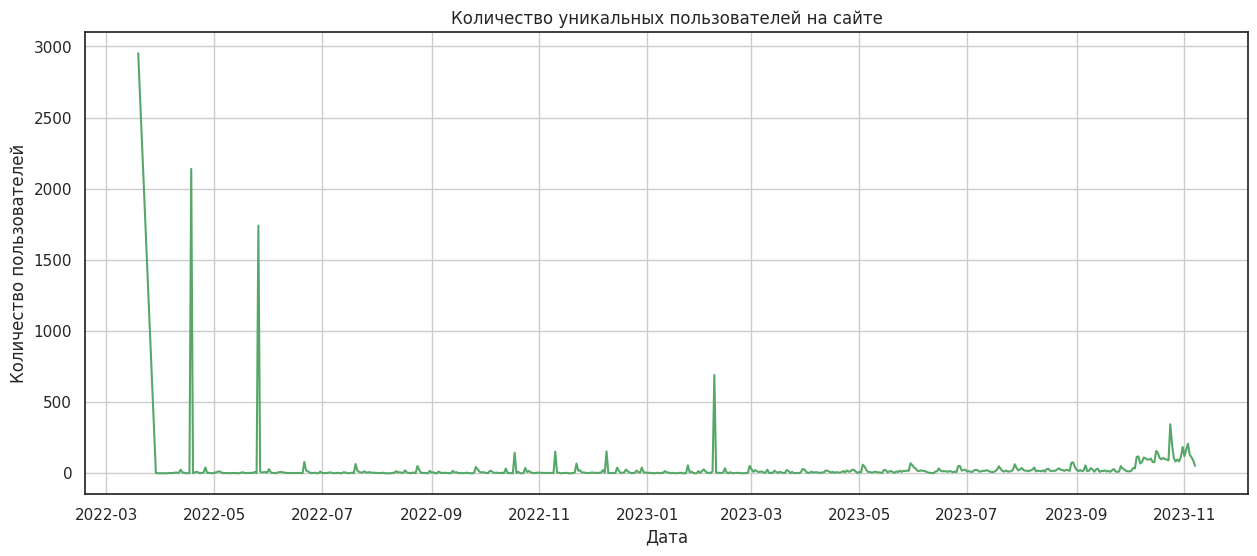

In [ ]:
# уберем из выборки рассылку и посмотрим активность пользователей по дням.

fig, ax = plt.subplots(figsize=(15,6))
ax.plot(total.query('status_sending.isna()').groupby('datetime')['user_id'].nunique(),\
        linestyle='-', color='g')
ax.set_title('Количество уникальных пользователей на сайте')
ax.set_xlabel('Дата')
ax.set_ylabel('Количество пользователей')
ax.grid()
plt.show()

Огромные пики в марте - июне 2022 года. Попробуем прояснить причину.

In [ ]:
total.query('status_sending.isna() & user_action != "Email признан валидным"\
& user_action !="Изменение часового пояса клиентов при изменении региона"\
& user_action !="Импорт при переносе исторической базы клиентов"')['user_action'].value_counts().head(15)



Переход на сайт                                                                                  11078
Просмотр “Дети”                                                                                  10793
Оформление заказа в операции Заказ - Создание неавторизованным                                    7810
Изменение статуса заказа в операции Заказ - Смена статуса.                                        6374
Оплата заказа                                                                                     5916
Просмотр продукта в операции 'Просмотр продукта'                                                  5793
Добавление продукта в список в операции 'Добавление в список — Просмотренные продукты'            5791
Пожертвование — разово                                                                            5527
Редактирование клиента в блоке сценария 'Подписка клиентов из исторического импорта - Шаги 2'     2560
Показ попапа Подписка на вебпуши                                         

Заказчик сказал, что пики уникальных пользователей в марте - июня 2022 связаны с импортом данных. Проверим это, убрав их из датасета.

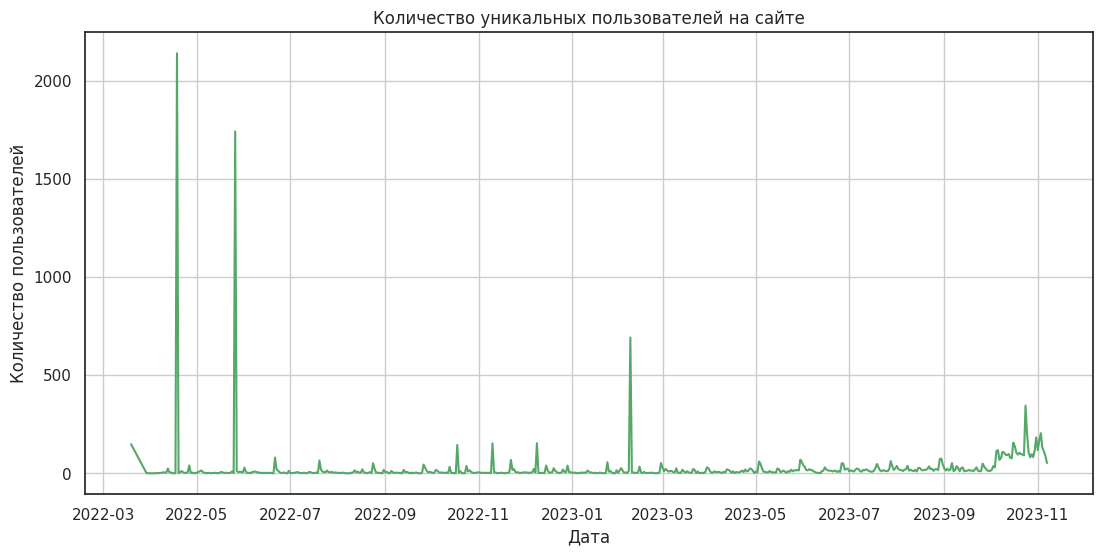

In [ ]:
fig, ax = plt.subplots(figsize=(13,6))
ax.plot(total.query('status_sending.isna() & user_action != "Email признан валидным"\
& user_action !="Изменение часового пояса клиентов при изменении региона"\
& user_action !="Импорт при переносе исторической базы клиентов"')
.groupby('datetime')['user_id'].nunique(), linestyle='-', color='g')
ax.set_title('Количество уникальных пользователей на сайте')
ax.set_xlabel('Дата')
ax.set_ylabel('Количество пользователей')
ax.grid()
plt.show()

От мартовского 2022 пика мы избавились, убрав из выборки технические действия пользователей, но пики мая и июня 2022 г. убрать не удалось. По просьбе заказчика, ограничем датасет и уберем данные пики.

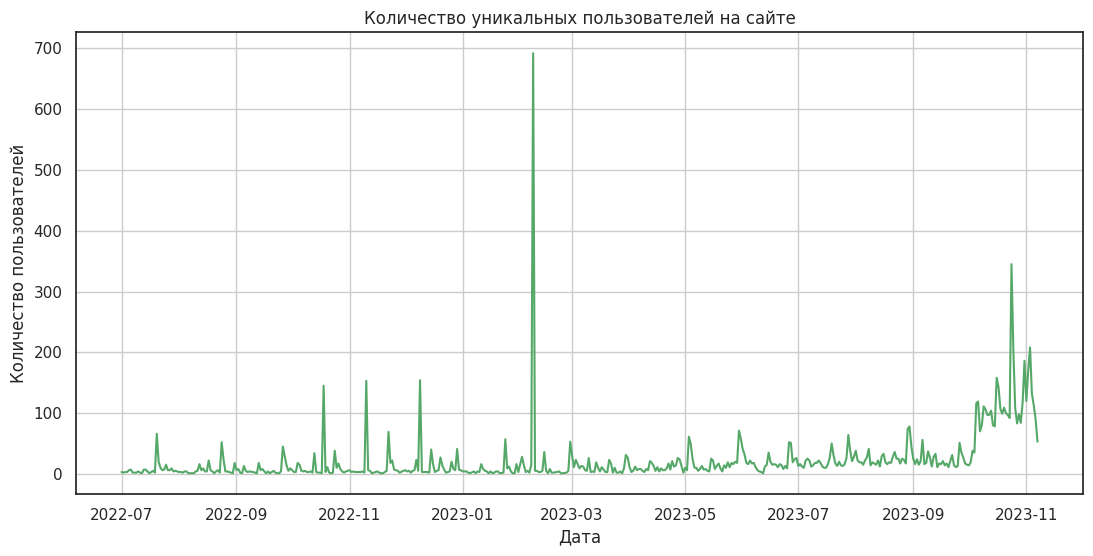

In [ ]:
total_new = total.query('datetime > "2022-06-30"')

fig, ax = plt.subplots(figsize=(13,6))
ax.plot(total_new.query('status_sending.isna()').groupby('datetime')['user_id']
        .nunique(), linestyle='-', color='g')
ax.set_title('Количество уникальных пользователей на сайте')
ax.set_xlabel('Дата')
ax.set_ylabel('Количество пользователей')
ax.grid(which='both')

plt.show()

Ежедневная посещаемость сайта не линейная, есть пики и спады. В феврале 2023 большой пик посещений 1200-1600 уникальных пользователей. Мы просмотрели временной интервал чуть больше года, за этот период не прослеживается существенного роста уникальных посетителей. Позже посмотрим количество уникальных пользователей по неделям и месяцам.

Посмотрим среднюю посещаемость сайта.

In [ ]:
print("Среднее количество уникальных пользователей в день:")
print((total_new.query('status_sending.isna()').groupby('datetime')['user_id'].nunique()).mean())
print("Средняя посещаемость сайта в день:")
print((total_new.query('status_sending.isna()').groupby('datetime')['user_id'].count()).mean())

Среднее количество уникальных пользователей в день:
22.80290456431535
Средняя посещаемость сайта в день:
154.68464730290455


#### Анализ рассылок

Посмотрим активность пользователей по рассылкам

In [ ]:
total['status_sending'].value_counts()

Dispatch               197828
MailingSend            197345
MailingOpen             31723
MailingClick             4594
MailingNotDelivered      2082
MailingUnsubscribe        632
MailingNotSent            483
Name: status_sending, dtype: int64

Отобразим данные на графике-воронке.

In [ ]:
#import plotly.express as px
#fig = px.funnel(total, x='user_id')
#fig.show()

14% рассылок открывается, из них в 16% происходят клики по письмам. Стоит посмотреть как эти показатели меняются со временем.

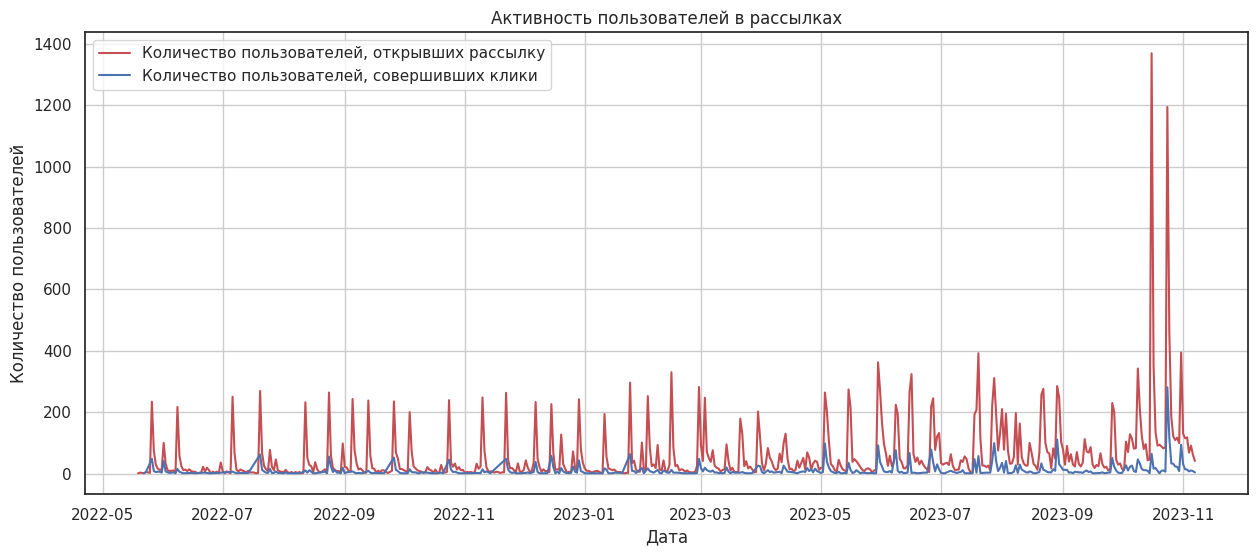

In [ ]:
fig, ax = plt.subplots(figsize=(15,6))
ax.plot(total.query('status_sending == "MailingOpen"')
.groupby('datetime')['user_id'].count(), linestyle='-', \
        label='Количество пользователей, открывших рассылку', color='r')
ax.plot(total.query('status_sending == "MailingClick"')
.groupby('datetime')['user_id'].count(), linestyle='-',
        label='Количество пользователей, совершивших клики', color='b')
ax.set_title('Активность пользователей в рассылках')
ax.set_xlabel('Дата')
ax.set_ylabel('Количество пользователей')
ax.legend(loc='upper left')
ax.grid(which='both')

plt.show()

Наблюдается незначительный рост открытия и кликов рассылок.

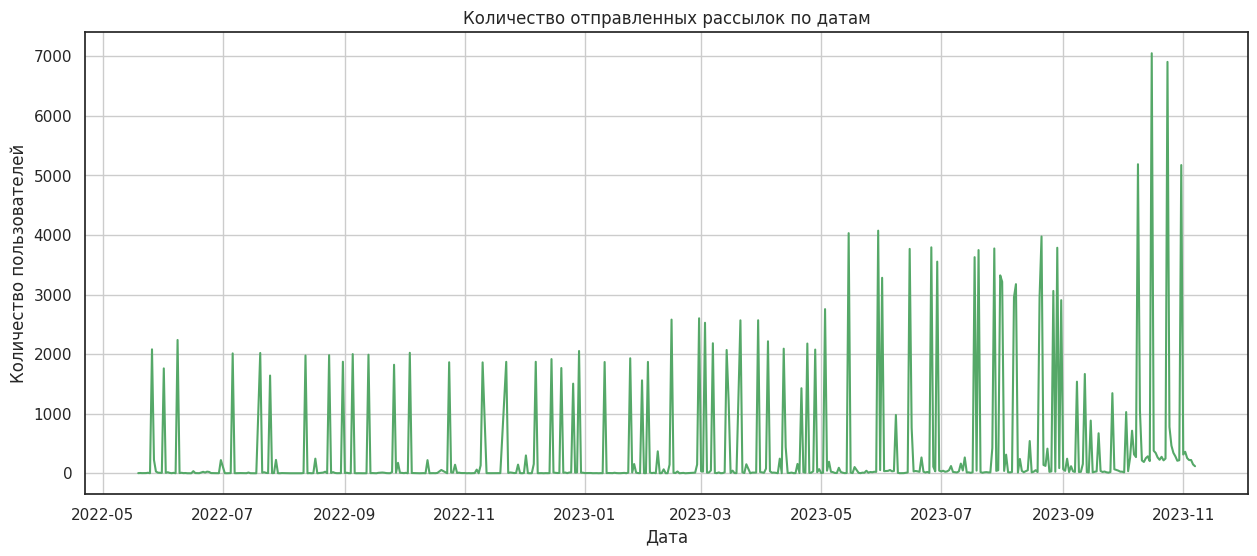

In [ ]:
fig, ax = plt.subplots(figsize=(15,6))
ax.plot(total.query('status_sending == "MailingSend"')
.groupby('datetime')['user_id'].count(), linestyle='-', color='g')
ax.set_title('Количество отправленных рассылок по датам')
ax.set_xlabel('Дата')
ax.set_ylabel('Количество пользователей')
ax.grid(which='both')

plt.show()

Но как мы видим, рост открытий и кликов происходит за счет увеличения объема рассылки. С середины сентября 2023 год произошел спад отправок рассылок (с 12 тыс. до 8 тыс.)

Посмотрим есть ли зависимость пиков рассылок от пиков платежей.

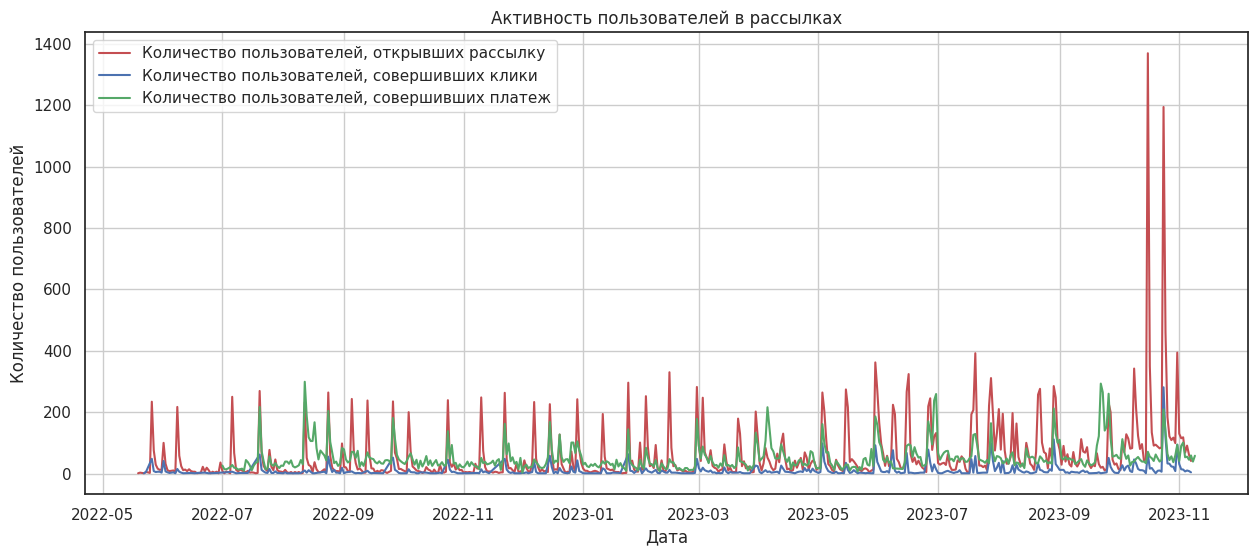

In [ ]:
fig, ax = plt.subplots(figsize=(15,6))
ax.plot(total.query('status_sending == "MailingOpen"')
.groupby('datetime')['user_id'].count(), linestyle='-', label='Количество пользователей, открывших рассылку', color='r')
ax.plot(total.query('status_sending == "MailingClick"')
.groupby('datetime')['user_id'].count(), linestyle='-', label='Количество пользователей, совершивших клики', color='b')
ax.plot(payments.query('order_datetime > "2022-06-30" & paid_status == "Paid"')
.groupby('order_datetime')['user_id'].count(), linestyle='-', label='Количество пользователей, совершивших платеж', color='g')
ax.set_title('Активность пользователей в рассылках')
ax.set_xlabel('Дата')
ax.set_ylabel('Количество пользователей')
ax.legend(loc='upper left')
ax.grid(which='both')

plt.show()

На графике видно, что пики платежей совпадают с пиками рассылок. Т.е. рассылки действительно работают эффективно.

**Активность пользователей не равномерная, иногда высокая, а иногда низкая. Попробуем понять, на какие типы рассылок пользователи реагируют активнее.**

In [ ]:
total.query('status_sending == "MailingOpen"').groupby('user_action')['user_id'].count().sort_values(ascending=False).head(20)

user_action
Счастливая история Марк Садартинов. Разовые Открытие         1717
Копия Фандрайзинговая. Герман Семенов Открытие               1607
Спасибо за разовое пожертвование (повторные) Открытие        1330
RFM. Письмо 1 Открытие                                        707
RFM. Письмо 3 Открытие                                        674
RFM. Письмо 2 Открытие                                        659
Фандрайзинговая. Ваня Зеленов Открытие                        642
Приглашение стать регулярным донором Открытие                 626
RFM. Письмо 4 Открытие                                        619
Счастливая история Лёня Селезень. Разовые Открытие            617
Копия Фандрайзинговая. Куракин Открытие                       569
Фандрайзинговая. Руслан Сафронов Открытие                     566
Новости для всех. Август 2023. Хирург Новиков Открытие        559
Фандрайзинговая. Алымовы Открытие                             556
Новости для разовых. Май 2023 Открытие                        54

Посмотрим распределение статусов в рассылке по уникальным пользователям.

In [ ]:
total.groupby('status_sending')['user_id'].nunique()

status_sending
Dispatch               11913
MailingClick            1293
MailingNotDelivered      841
MailingNotSent           325
MailingOpen             5221
MailingSend            11742
MailingUnsubscribe       376
Name: user_id, dtype: int64

В базе 19 279 уникальных пользователей. База для email маркетинга довольно живая, 64% пользователей открывают рассылку. Из них 31% кликает на ссылки и переходит на сайт.

In [ ]:
print(f'В среднем каждый пользователь получает писем:')
print((total.query('status_sending == "MailingSend"').groupby('user_id')\
 ['status_sending'].agg('count')).mean().round(0))

print(f'В среднем каждый пользователь открывает писем:')
print((total.query('status_sending == "MailingOpen"').groupby('user_id')\
 ['status_sending'].agg('count')).mean().round(0))

print(f'В среднем каждый пользователь делает клики в письмах:')
print((total.query('status_sending == "MailingClick"').groupby('user_id')\
 ['status_sending'].agg('count')).mean().round(0))

В среднем каждый пользователь получает писем:
17.0
В среднем каждый пользователь открывает писем:
6.0
В среднем каждый пользователь делает клики в письмах:
4.0


- Активность по дням недели

-Активность по времени суток


###Выводы


- Датасет состоит из более 2 млн. строчек, при этом содержит 19742 уникальных пользователя. Наиболее информативными стали столбцы с датой действия пользователя, действиями пользователями, информацией об email рассылках и статусах писем, названиях канала активности.

- Датасет содержить 1138 уникальных действий пользователя, но по факту их можно разделить на 3 основных группы: рассылка, активность на сайте, техническими моментами.

- Ежедневная посещаемость сайта не линейная, есть пики и спады. В среднем посещаемость сайта 869, а уникальных пользователя 116. В феврале 2023 большой пик посещений 1200-1600 уникальных пользователей. За временной интервал чуть больше года не прослеживается существенного роста уникальных посетителей на сайте в день. При дальнейшем анализе датасета появилась теория, что у мы видим не всех посетителей сайта, а только тех, кто получил email, поэтому пики посетителей на сайте тесно связаны с открытием рассылок.


 - База для email маркетинга довольно живая, 64% уникальных пользователя открывают рассылку. Из них 31% кликает на ссылки и переходит на сайт.

 - Однако по рассылкам результат другой, 14% всех рассылок открывается, из них в 16% происходят клики по письмам. На временной шкале наблюдается постепенно рост открытий и кликов, но незначительный.
Этот рост скорее всего происходит за счет прироста пользователей в рассылке.

- С середины сентября 2023 год произошел спад отправок рассылок (с 12 тыс. до 8 тыс.)

- Мы наблюдаем, что пики платежей совпадают с пиками рассылок. Т.е. рассылки действительно работают эффективно для сбора пожертвований.

### Анализ данных по платежам.

Выведем данные по платежам.

In [ ]:
payments.head()

order_id order_datetime  channel_id  \
0     37117     2021-10-14           1   
1     58434     2021-03-18           1   
2    102699     2022-11-23           9   
3    111808     2023-03-29           9   
4     67535     2021-06-16           1   

                                        product_name  order_price paid_status  \
0                           На уставную деятельность            1        Paid   
1                           На уставную деятельность           50        Paid   
2  Пожертвование Благотворительный фонд «АиФ. Доб...          100     notpaid   
3  Пожертвование Благотворительный фонд «АиФ. Доб...          300        Paid   
4                           На уставную деятельность          200        Paid   

   user_id  
0     2734  
1     2734  
2     2734  
3     2847  
4     2847

Проверим данные на выбросы, дубликаты и пропуски.

In [ ]:
payments.duplicated().sum()

0

Дубликатов нет, двигаемся дальше

In [ ]:
payments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54445 entries, 0 to 54444
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   order_id        54445 non-null  int64         
 1   order_datetime  54445 non-null  datetime64[ns]
 2   channel_id      54445 non-null  int64         
 3   product_name    54245 non-null  object        
 4   order_price     54445 non-null  int64         
 5   paid_status     54445 non-null  object        
 6   user_id         54445 non-null  int64         
dtypes: datetime64[ns](1), int64(4), object(2)
memory usage: 2.9+ MB


In [ ]:
payments.head()

order_id order_datetime  channel_id  \
0     37117     2021-10-14           1   
1     58434     2021-03-18           1   
2    102699     2022-11-23           9   
3    111808     2023-03-29           9   
4     67535     2021-06-16           1   

                                        product_name  order_price paid_status  \
0                           На уставную деятельность            1        Paid   
1                           На уставную деятельность           50        Paid   
2  Пожертвование Благотворительный фонд «АиФ. Доб...          100     notpaid   
3  Пожертвование Благотворительный фонд «АиФ. Доб...          300        Paid   
4                           На уставную деятельность          200        Paid   

   user_id  
0     2734  
1     2734  
2     2734  
3     2847  
4     2847

In [ ]:
payments['user_id'].nunique()

17339

У нас есть столбец Paid_status, в нем отражается информация прошел ли платеж. Посмотрим как отличаются данные, если рассматривать только прошедние пожертвования.

In [ ]:
payments.query('paid_status == "Paid"').info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41079 entries, 0 to 54444
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   order_id        41079 non-null  int64         
 1   order_datetime  41079 non-null  datetime64[ns]
 2   channel_id      41079 non-null  int64         
 3   product_name    40956 non-null  object        
 4   order_price     41079 non-null  int64         
 5   paid_status     41079 non-null  object        
 6   user_id         41079 non-null  int64         
dtypes: datetime64[ns](1), int64(4), object(2)
memory usage: 2.5+ MB


Мы видим, что 13 365 платежей по какой-то причине не прошло. Это почти 25%. Стоит подробно разобраться в причине.



Посмотрим какой размер платежей и в каком размере бывает.

In [ ]:
payments['order_price'].count()

54445

In [ ]:
payments['order_price'].value_counts().head(10)

500     11743
300      9393
100      7780
200      5749
1000     4861
1500     2276
50       2031
150      1301
2000      885
3000      810
Name: order_price, dtype: int64

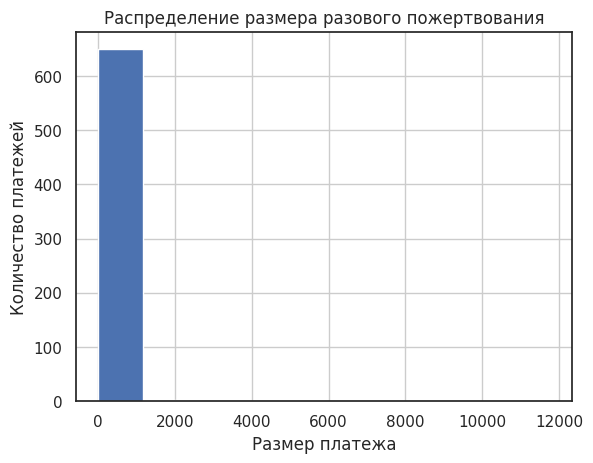

In [ ]:
payments['order_price'].value_counts().hist()
plt.xlabel('Размер платежа')
plt.ylabel('Количество платежей')
plt.title('Распределение размера разового пожертвования');

На графике видно, что основная масса платежей до 1 тыс. рублей

#### Дата действия

In [ ]:
payments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54445 entries, 0 to 54444
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   order_id        54445 non-null  int64         
 1   order_datetime  54445 non-null  datetime64[ns]
 2   channel_id      54445 non-null  int64         
 3   product_name    54245 non-null  object        
 4   order_price     54445 non-null  int64         
 5   paid_status     54445 non-null  object        
 6   user_id         54445 non-null  int64         
dtypes: datetime64[ns](1), int64(4), object(2)
memory usage: 2.9+ MB


Посмотрим как распределена платежи пользователей по дате.

In [ ]:
print('Все пользователи')
# посчитаем количество уникальных пользователей, делавших платежи на каждую дату
dapu = payments.groupby('order_datetime')['user_id'].nunique()
display(dapu.head(5))

# также интересно посмотреть распределение пользователей, которые провели оплату.

sp = payments.query('paid_status == "Paid"') # данные только оплаченные

print()
print('Пользователи оплатившие пожертвования')
dapu_wp = sp.groupby('order_datetime')['user_id'].nunique()
display(dapu_wp.head(5))

Все пользователи


order_datetime
2021-01-01    11
2021-01-02    15
2021-01-03    14
2021-01-04    17
2021-01-05    10
Name: user_id, dtype: int64


Пользователи оплатившие пожертвования


order_datetime
2021-01-01    11
2021-01-02    15
2021-01-03    14
2021-01-04    17
2021-01-05    10
Name: user_id, dtype: int64

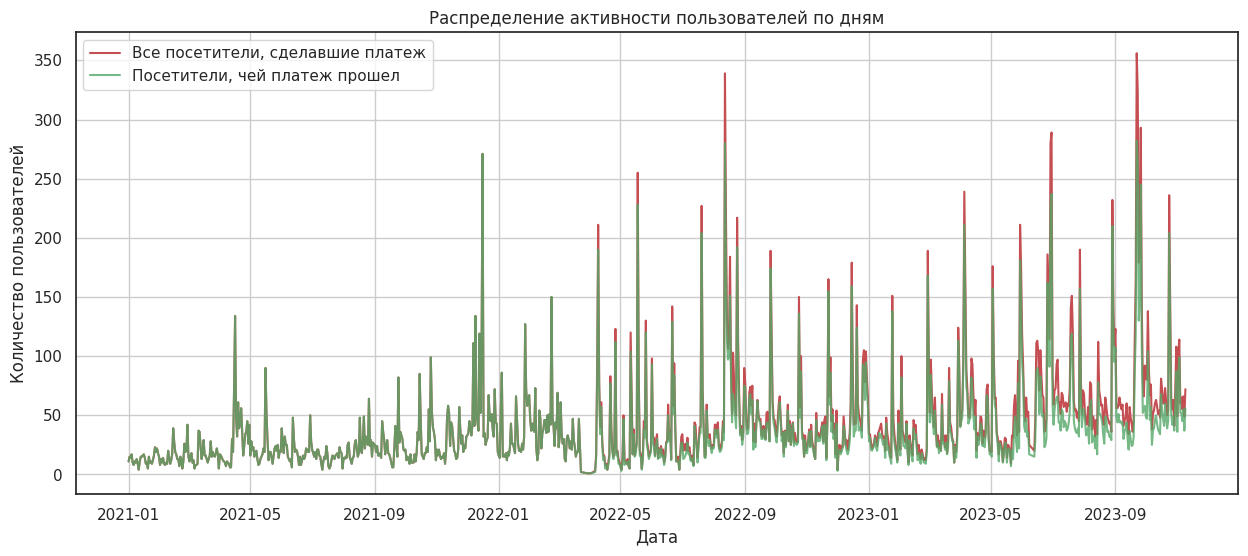

In [ ]:
# Построим визуализацию наших результатов для большей наглядности.
fig, ax = plt.subplots(figsize=(15, 6))
ax.plot(dapu, linestyle='-', label='Все посетители, сделавшие платеж', color='r')
ax.plot(dapu_wp, linestyle='-', color='g', label='Посетители, чей платеж прошел', alpha=0.8)
ax.set_title('Распределение активности пользователей по дням')
ax.set_xlabel('Дата')
ax.set_ylabel('Количество пользователей')
ax.legend(loc='upper left')
ax.grid()
plt.show()

Прослеживается небольшой пострепенный рост платежной активности, а также есть постоянно всплески. Ранее мы уже прослеживали рост платежей после email-рассылок. Также стоит обратить внимание, что непрошедние платежи появляются только с апреля 2022.


Посмотрим также распределение платежей по неделям.


Количество уникальных пользователей совершивших пожертвование в неделю


order_datetime
2021-01-04     56
2021-01-11     65
2021-01-18     93
2021-01-25     71
2021-02-01    118
Freq: W-MON, Name: user_id, dtype: int64


Количество уникальных пользователей по неделям, чье пожертвование прошло


order_datetime
2021-01-04     56
2021-01-11     65
2021-01-18     93
2021-01-25     71
2021-02-01    118
Freq: W-MON, Name: user_id, dtype: int64

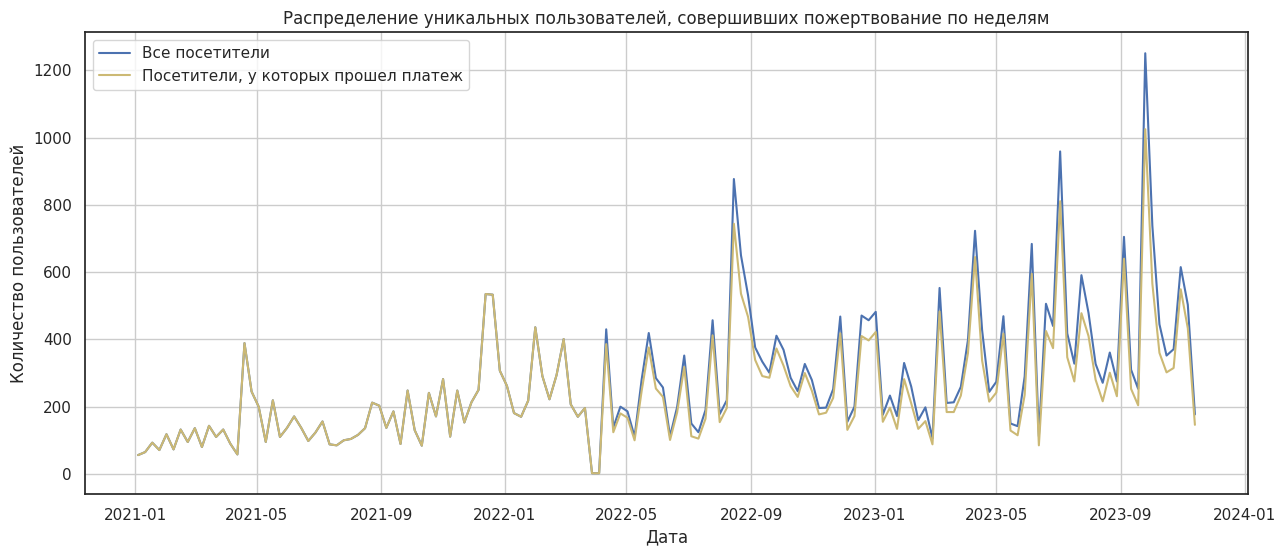

In [ ]:
# группируем даты по неделям.
payments['order_datetime'] = pd.to_datetime(payments['order_datetime'])
wapu = payments.groupby([pd.Grouper(key='order_datetime',freq='W-Mon')])['user_id'].nunique()
# расчитаем количество пользователей по неделям, оплатившим пожертвование
sp['order_datetime'] = pd.to_datetime(sp['order_datetime'])
wapu_wp = sp.groupby([pd.Grouper(key='order_datetime',freq='W-Mon')])['user_id'].nunique()
# визуализируем данные
print()
print('Количество уникальных пользователей совершивших пожертвование в неделю')
display(wapu.head(5))
print()
print('Количество уникальных пользователей по неделям, чье пожертвование прошло')
display(wapu_wp.head(5))


fig, ax = plt.subplots(figsize=(15, 6))
ax.plot(wapu, linestyle='-', label='Все посетители', color='b')
ax.plot(wapu_wp, linestyle='-', label='Посетители, у которых прошел платеж', color='y')
ax.set_title('Распределение уникальных пользователей, совершивших пожертвование по неделям')
ax.set_xlabel('Дата')
ax.set_ylabel('Количество пользователей')
ax.legend(loc='upper left')
ax.grid()
plt.show()


Как и в ежедневном графике прослеживается постепенные рост пользователей, делающих пожертвование. Стоит обратить внимание, что с апреля 2022 появляются неоплаченные счета.

Посмотрим распределние по месяцам.

Количество всех пользователей в месяц, создавших счета



order_datetime
2022-04-30     863
2023-11-30     558
2023-02-28     769
2023-10-31    1700
2022-08-31    2218
Name: user_id, dtype: int64


Количество пользователей в месяц, оплативших пожертвование



order_datetime
2021-03-31     466
2023-10-31    1451
2022-06-30     794
2023-07-31    1435
2023-09-30    2010
Name: user_id, dtype: int64

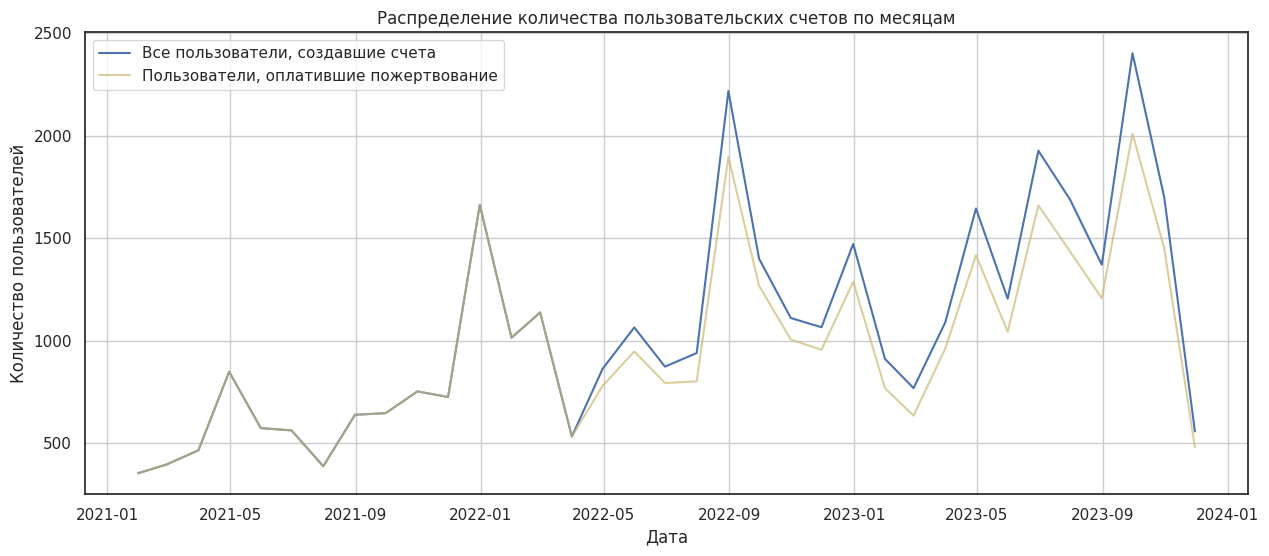

In [ ]:
# группируем даты по месяцам и расчитываем количество пользователей

print('Количество всех пользователей в месяц, создавших счета')
print()
mapu = payments.groupby([pd.Grouper(key='order_datetime',freq='M')])['user_id'].nunique()
display(mapu.sample(5))
print()

# рассчитываем количество пользователей по месяцам, оплатившим пожертвование.
print('Количество пользователей в месяц, оплативших пожертвование')
print()
mapu_wp = sp.groupby([pd.Grouper(key='order_datetime',freq='M')])['user_id'].nunique()
display(mapu_wp.sample(5))

# Визуализируем данные

fig, ax = plt.subplots(figsize=(15, 6))
ax.plot(mapu, linestyle='-', label='Все пользователи, создавшие счета', color='b')
ax.plot(mapu_wp, linestyle='-', color='y', label='Пользователи, оплатившие пожертвование', alpha=0.7)
ax.set_title('Распределение количества пользовательских счетов по месяцам')
ax.set_xlabel('Дата')
ax.set_ylabel('Количество пользователей')
ax.legend(loc='upper left')
ax.grid()
plt.show()


Как видим в месячных данных уже четко прослеживатся постепенный рост посетителей с заметными пиками.

Посмотрим также распределение сумм платежей по дате.

In [ ]:
print('Все платежи')
pt = payments.pivot_table(index='order_datetime', values='order_price', aggfunc='sum')
display(pt.sample(5))
#стоит посмотреть также распределение без неоплаченных и наложить эти графики друг на друга, может быть интересная картина будет.
print('Только оплаченные платежи')
bpt = sp.pivot_table(index='order_datetime', values='order_price', aggfunc='sum')
display(pt.sample(5))

Все платежи


order_price
order_datetime             
2021-08-21            64770
2021-01-28            14200
2022-07-11            13730
2021-02-19            18510
2023-03-12            16873

Только оплаченные платежи


order_price
order_datetime             
2023-10-17            75030
2022-05-09            13070
2022-06-15            15036
2023-04-18           101754
2022-01-14            30960

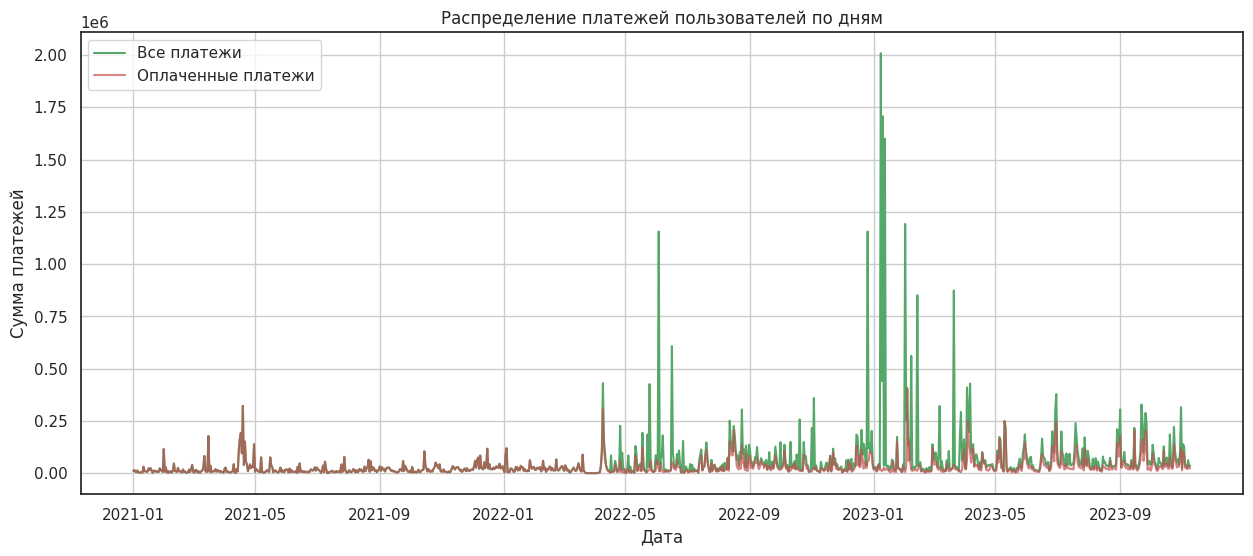

In [ ]:
fig, ax = plt.subplots(figsize=(15,6))
ax.plot(pt, linestyle='-', label='Все платежи', color='g')
ax.plot(bpt, linestyle='-', color='r', label='Оплаченные платежи', alpha=0.7)
ax.set_title('Распределение платежей пользователей по дням')
ax.set_xlabel('Дата')
ax.set_ylabel('Сумма платежей')
ax.legend(loc='upper left')
ax.grid()
plt.show()

Очень интересная картина, до апреля 2022 у нас не было неоплаченных счетов, потом они появились. Стоит проанализировать причину. Отметим также, что сумма неоплаченных пожертвований намного больше, что оплаченых.

Также стоит отметить, что прослеживается рост уникальных пользователей, но при этом сумма платежей растет не сильно.

Посмотрим в какой день недели сколько пожертвований.

In [ ]:
sp['day_of_week'] = sp.order_datetime.dt.day_name()
sp.groupby('day_of_week')['order_price'].count()

day_of_week
Friday       6309
Monday       5011
Saturday     4896
Sunday       4216
Thursday     6895
Tuesday      6924
Wednesday    6828
Name: order_price, dtype: int64

В будни количество платежей больше, чем в выходные дни.

#### Платежи

Посмотрим основные характеристики столбца с платежами. Посмотрим статистические характеристики выборки.


In [ ]:
print("С неоплаченными платежами")
display(payments['order_price'].describe()) # посмотрим характеристики со статусом "не оплачен"
print()
print("Только оплаченные платежи")
sp['order_price'].describe() # характеристики без неоплаченных пожертвований

С неоплаченными платежами


count     54445.00
mean       1079.33
std       10976.44
min           0.00
25%         150.00
50%         300.00
75%         500.00
max     1100000.00
Name: order_price, dtype: float64


Только оплаченные платежи


count    41079.00
mean       760.95
std       2722.20
min          0.00
25%        150.00
50%        300.00
75%        500.00
max     200000.00
Name: order_price, dtype: float64

Как мы уже видели на графике выше, в неоплаченных платежах есть очень большие суммы (максимум 1,1 млн. против 200 тыс. в оплаченных), которые сильно влияют на среднее и стандартное отклонение.

Среднее (761) у нас в 2 раза больше, чем медиана(300). Очень большое стандартное отклонение (2722), а также мы видим, что 75% данных у нас лежит в интервале до 500 рублей. Т.е. по сути основной пул платежей у нас все же небольшие суммы. Но есть и сверхбольшие пожертвования, т.к. максимум лежит в 200 000 рублей.


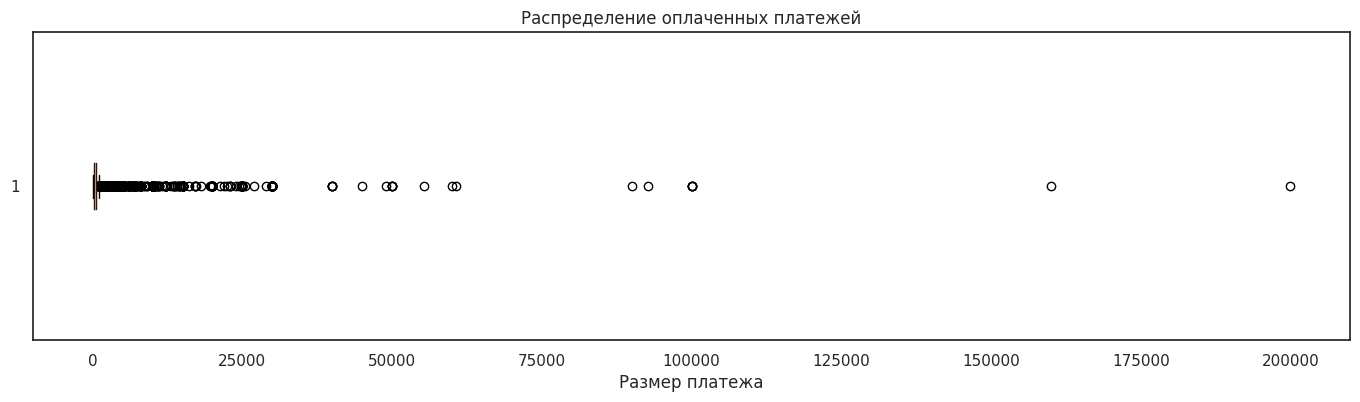

In [ ]:
fig, ax = plt.subplots(figsize=(17,4))
ax.boxplot(sp['order_price'], vert=False)

plt.title('Распределение оплаченных платежей')
plt.xlabel('Размер платежа')

plt.show();


У нас есть разные платежи. Большинство пользователей платит не больше нескольких тысяч. Однако, есть и очень большие платежи. Самый большой - 200 тыс.

#### Другие параметры

Посмотрим на поле название продукта.

In [ ]:
payments['product_name'].value_counts()

На уставную деятельность                                                                                                    11568
Пожертвование Благотворительный фонд «АиФ. Доброе сердце» Пожертвование (хочу помочь)                                        5279
Пожертвование Благотворительный фонд «АиФ. Доброе сердце» Пожертвование на уставную деятельность БФ «АиФ. Доброе сердце»     2378
Пожертвование Благотворительный фонд «АиФ. Доброе сердце» Егор Цуканов                                                       2141
Пожертвование Благотворительный фонд «АиФ. Доброе сердце» Софья Пантурова                                                    1408
                                                                                                                            ...  
Пожертвование Благотворительный фонд «АиФ. Доброе сердце» Дарина Махмутова                                                      1
Пожертвование Благотворительный фонд «АиФ. Доброе сердце» Милана Максимова                

Посмотрим лидеров, на что жертвуют пользователи

In [ ]:
payments['product_name'].value_counts().head(25)

На уставную деятельность                                                                                                    11568
Пожертвование Благотворительный фонд «АиФ. Доброе сердце» Пожертвование (хочу помочь)                                        5279
Пожертвование Благотворительный фонд «АиФ. Доброе сердце» Пожертвование на уставную деятельность БФ «АиФ. Доброе сердце»     2378
Пожертвование Благотворительный фонд «АиФ. Доброе сердце» Егор Цуканов                                                       2141
Пожертвование Благотворительный фонд «АиФ. Доброе сердце» Софья Пантурова                                                    1408
Пожертвование Благотворительный фонд «АиФ. Доброе сердце» Демид Лебедев                                                      1398
Пожертвование Благотворительный фонд «АиФ. Доброе сердце» Максим Широкин                                                     1267
Пожертвование Благотворительный фонд «АиФ. Доброе сердце» Руслан Сафронов                 

Для анализа объеденим все пожертвования с именем в группу "Пожертвование на помощь конкретному лицу", а все общие пожертвования объеденим в группу "Общее пожертвование фонду"

In [ ]:
sp['product_name'] = sp['product_name'].astype(str)

In [ ]:
def purpose_grouping(cell: 'str') -> str:
  if 'устав' in cell or 'хочу помочь' in cell:
    return 'Общее пожертвование фонду'
  return 'Пожертвование на помощь конкретному лицу'

sp['donation'] = sp.product_name.apply(purpose_grouping)
sp['donation'].value_counts() / len(sp)

Пожертвование на помощь конкретному лицу   0.61
Общее пожертвование фонду                  0.39
Name: donation, dtype: float64

Люди чаще делают пожертвования на помочь конкретному лицу (61%). Платежи на общие задачи - 39%.

Посмотрим соотношение пожертвований в группах по сумме платежей.

In [ ]:
sp.groupby('donation')['order_price'].sum()

donation
Общее пожертвование фонду                   12322659
Пожертвование на помощь конкретному лицу    18936432
Name: order_price, dtype: int64

Посмотрим платежи по группам в динамике по дате.

In [ ]:
sp.pivot_table(index='order_datetime', columns='donation', values='order_price', aggfunc='sum')


donation        Общее пожертвование фонду  \
order_datetime                              
2021-01-01                       11143.00   
2021-01-02                       15541.00   
2021-01-03                        7353.00   
2021-01-04                        5020.00   
2021-01-05                       13200.00   
...                                   ...   
2023-11-05                       13940.00   
2023-11-06                        7701.00   
2023-11-07                        5255.00   
2023-11-08                        9365.00   
2023-11-09                        6850.00   

donation        Пожертвование на помощь конкретному лицу  
order_datetime                                            
2021-01-01                                           NaN  
2021-01-02                                           NaN  
2021-01-03                                           NaN  
2021-01-04                                           NaN  
2021-01-05                                           NaN  
...                                                  ...  
2023-11-05                                      14485.00  
2023-11-06                                      12197.00  
2023-11-07                                      33393.00  
2023-11-08                                      12857.00  
2023-11-09                                      17205.00  

[1027 rows x 2 columns]

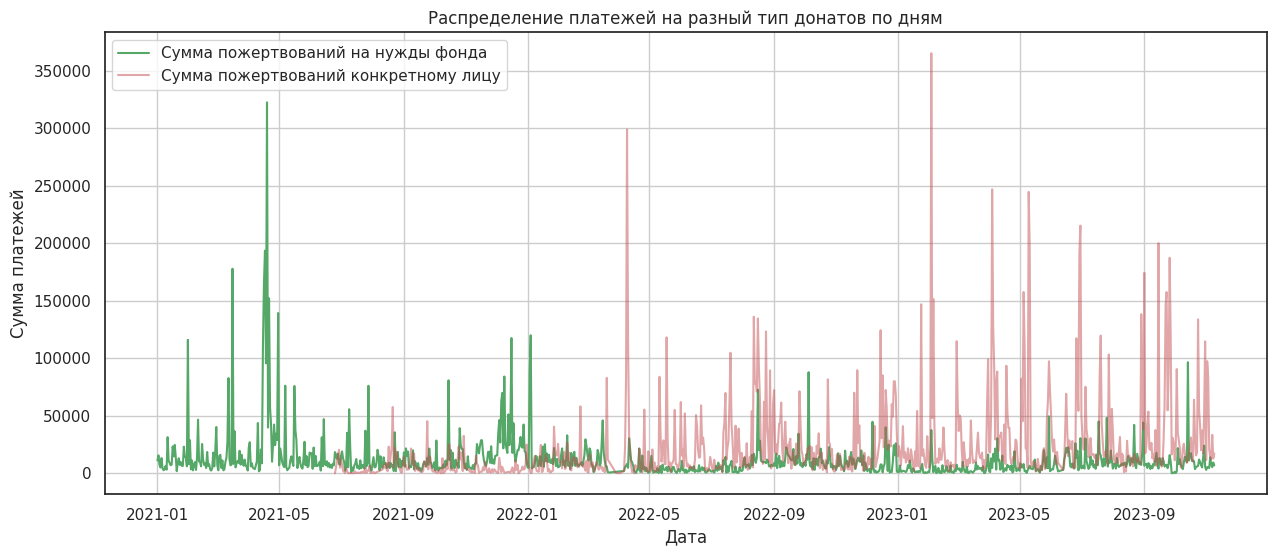

In [ ]:
fig, ax = plt.subplots(figsize=(15,6))
ax.plot(sp.query('donation == "Общее пожертвование фонду"').pivot_table(index='order_datetime', columns='donation',\
                       values='order_price', aggfunc='sum'), \
        linestyle='-', label='Сумма пожертвований на нужды фонда', color='g')
ax.plot(sp.query('donation == "Пожертвование на помощь конкретному лицу"').pivot_table(index='order_datetime', columns='donation',\
                       values='order_price', aggfunc='sum'), \
        linestyle='-', label='Сумма пожертвований конкретному лицу', color='r', alpha=0.5)
ax.set_title('Распределение платежей на разный тип донатов по дням')
ax.set_xlabel('Дата')
ax.set_ylabel('Сумма платежей')
ax.legend(loc='upper left')
ax.grid()
plt.show()

до июня 2021 года пожертвования были только на нужнды фонда. С июня 2021 появились платежи на помощь конкретным людям, и они постоянно растут, есть яркие всплески.



#### ID пользователя.

Посмотрим какое количество пожертвований сделали  пользователи.

In [ ]:
sp.groupby('user_id')['order_price'].count().value_counts().head(15)


1     10753
2      1750
3       700
4       432
5       274
6       187
7       152
8       139
10      105
9        99
12       83
11       74
13       61
14       61
15       61
Name: order_price, dtype: int64

Большинство пользователей (62%) делали пожертвование только один раз.

Посчитаем сколько в среднем пожертвований на пользователя.

In [ ]:
len(sp) / sp['user_id'].nunique()

2.6705890001300223

В среднем по базе на одного пользователя получается 2,67 пожертвований.

### Выводы
- Датасет с платежами состоит из 54445 строк и содежит информацию о дате платежа, статусе оплаты, виде пожертвования (на уставную деятельность или конкретному лицу), а также сумме платежа и пользователей, совершившем пожертвование.
- В датасете содержится информация об 17339 уникальных пользователя.
- 25% платежей по какой-то причине не прошли. При этом они появились только с апреле 2022 года. Отметим также, что сумма неоплаченных пожертвований намного больше и достигает 2 млн. рублей в день. Тогда как сумма оплаченных пожертвований не превышает 400 тыс. руб. за день.

Также стоит отметить, что прослеживается рост уникальных пользователей, но при этом сумма платежей растет не сильно.
- 22% пользователя за один раз жертвуют 500 руб,</br> 17% - 300 руб, </br>14% - 100 руб, </br>11% - 200 руб, </br>9% - 1000 руб, </br>4% - 1500 руб. </br> Т.е. у большинства пользователей размер платежа составляет не больше 1000 руб.
- Большинство пользователей (62%) сделали пожертвование только один раз.
- На временной шкале прослеживается небольшой постепенный рост количества уникальных пользователей, которые совершают пожертвования, а также есть постоянно всплески. Ранее мы уже прослеживали рост платежей после email-рассылок. При этом на временной шкале нет роста суммы платежей.
- В будни количество платежей больше, чем в выходные дни.
- люди чаще делают пожертвования на помочь конкретному лицу (61% против 39% на общие задачи). Платежи на помощь конкретным людям появились в июня 2021 и они постоянно растут.



## Аналитическая часть

### Продуктовые метрики.

Расчитаем количество уникальных пользователей за сутки, неделю и месяц на сайте фонда (метрики DAU, WAU, MAU).

Для удобства расчетов, выделим номер недели, месяца и года из даты и укажем их в дополнительных столбцах.

In [ ]:
total['day_of_week'] = total.datetime.dt.day_name()
total['number_month'] = total['datetime'].dt.month
total['year'] = total['datetime'].dt.year
total[['datetime', 'day_of_week', 'number_month', 'year']].head()

datetime day_of_week  number_month    year
0 2022-03-19    Saturday          3.00 2022.00
1 2022-04-18      Monday          4.00 2022.00
2 2022-04-18      Monday          4.00 2022.00
3 2022-11-23   Wednesday         11.00 2022.00
4 2022-11-23   Wednesday         11.00 2022.00

Для начала посмотрим дневную зависимость

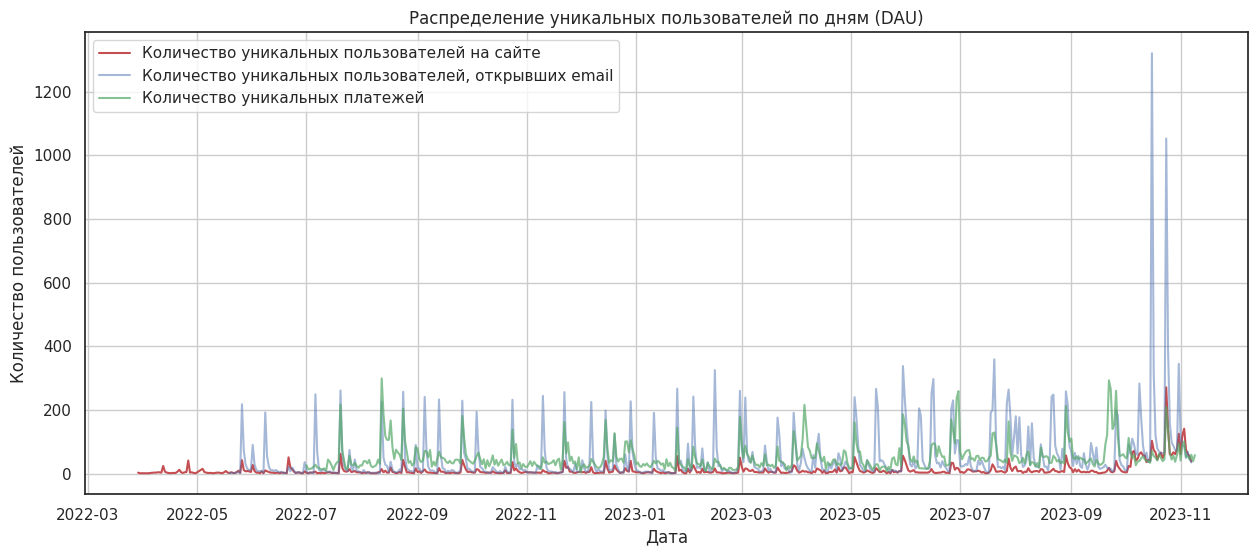

In [ ]:
#берем только действие "Переход на сайт"
dau = total.query('user_action == "Переход на сайт"').groupby('datetime')['user_id'].nunique()

# визуализируем показатель DAU по временной оси.
fig, ax = plt.subplots(figsize=(15, 6))
ax.plot(dau, linestyle='-', label='Количество уникальных пользователей на сайте', color='r')

# выведем на этом же графике данные уникальным открытиям email-рассылок
ax.plot(total.query('status_sending == "MailingOpen"')\
        .groupby('datetime')['user_id'].nunique(), linestyle='-',\
        label='Количество уникальных пользователей, открывших email',color='b', alpha = 0.5)

# выведем на этом же графике данные по уникальным платежам по дням
ax.plot(sp.query('order_datetime > "2022-06-30"')\
        .groupby('order_datetime')['order_id'].count(), linestyle='-', \
        color = 'g', alpha=0.7, label='Количество уникальных платежей')
ax.set_title('Распределение уникальных пользователей по дням (DAU)')
ax.set_xlabel('Дата')
ax.set_ylabel('Количество пользователей')
ax.legend(loc='upper left')
ax.grid()

По графику видны всплески посетителей на сайте и они совпадают по времени с рассылками и платежами. По количеству уникальных пользователей не прослеживается существенного роста со временем.

!!!! Однако я считаю, что мы имеем не полную информацию о посетителях, а только о тех кто перешел с рассылки, поэтому мы и видим такую четкую зависимость пиков посещей от рассылки.

Теперь посмотрим распределение уникальных пользователей в недельном интервале

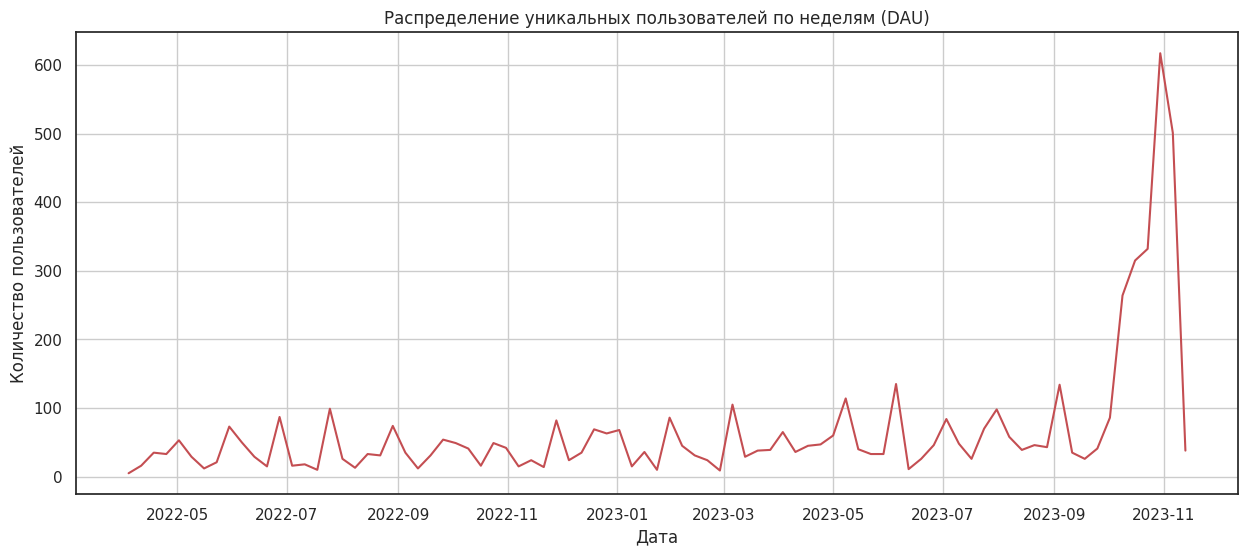

In [ ]:
# группируем даты по неделям.
wau = total.query('user_action == "Переход на сайт"').groupby([pd.Grouper(key='datetime',freq='W-Mon')])['user_id'].nunique()

# визуализируем показатель WAU по временной оси.
fig, ax = plt.subplots(figsize=(15, 6))
ax.plot(wau, linestyle='-', color='r')
ax.set_title('Распределение уникальных пользователей по неделям (DAU)')
ax.set_xlabel('Дата')
ax.set_ylabel('Количество пользователей')
ax.grid()
plt.show()

Пики также прослеживаются, а также виден небольшой рост.

Посмотрим изменения количества уникальных пользователей на сайте в месячном интервале.

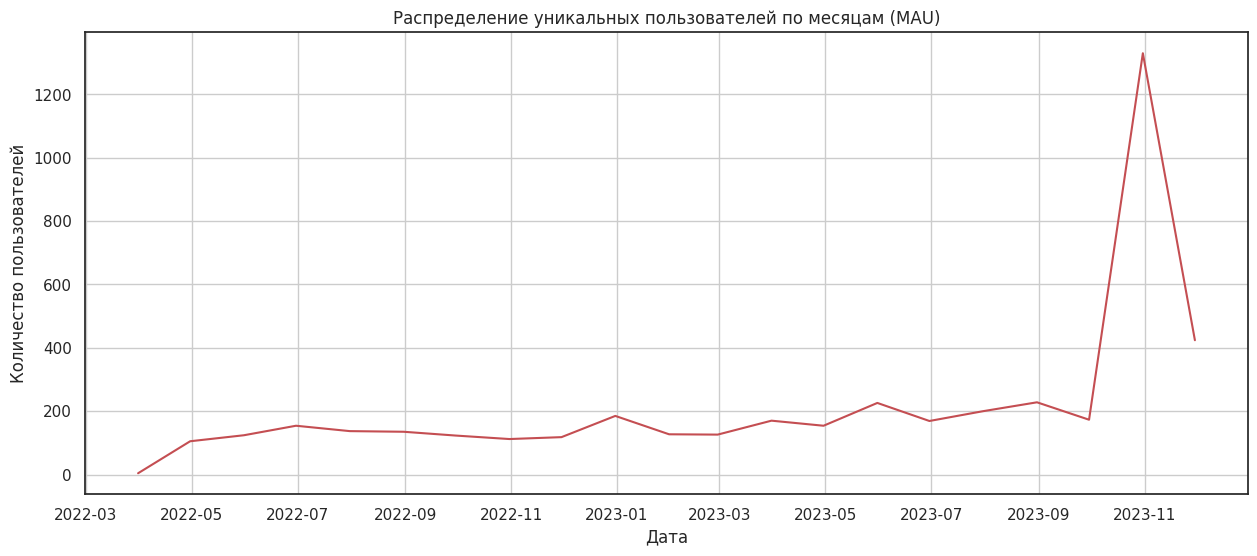

In [ ]:
# группируем даты по месяцам и расчитываем количество пользователей

mau = total.query('user_action == "Переход на сайт"')\
.groupby([pd.Grouper(key='datetime',freq='M')])['user_id'].nunique()

# визуализируем показатель WAU по временной оси.
fig, ax = plt.subplots(figsize=(15, 6))
ax.plot(mau, linestyle='-', color='r')
ax.set_title('Распределение уникальных пользователей по месяцам (MAU)')
ax.set_xlabel('Дата')
ax.set_ylabel('Количество пользователей')
ax.grid()
plt.show()

Прослеживается общий постепенный рост MAU, однако в некоторые месяцы MAU значительно выше, чем в другие. Стоит проанализировать это подробнее.

Расчитаем показатель sticky rate по месяцам.

In [ ]:
# расчитаем WAU
wau = total.query('user_action == "Переход на сайт"')\
.groupby(['year', 'number_month', 'day_of_week'])['user_id'].agg('nunique').reset_index()
wau.rename(columns={'user_id': 'wau'}, inplace=True)
# расчитаем MAU
mau = total.query('user_action == "Переход на сайт"')\
.groupby(['year', 'number_month'])['user_id'].agg('nunique').reset_index()
mau.rename(columns={'user_id': 'mau'}, inplace=True)

#объеденим таблицы по месяцу и году.
total_visit = wau.merge(mau, on=["year", "number_month"])
total_visit = total_visit.merge(total.query('user_action == "Переход на сайт"'),\
                                on=["year", "number_month", "day_of_week"])


In [ ]:
# Вычислим sticky_month
total_visit['sticky'] = total_visit['wau'] / total_visit['mau'] * 100
total_visit.head()

year  number_month day_of_week  wau  mau  action_id      user_action  \
0 2022.00          3.00     Tuesday    3    4      33386  Переход на сайт   
1 2022.00          3.00     Tuesday    3    4      33328  Переход на сайт   
2 2022.00          3.00     Tuesday    3    4      33335  Переход на сайт   
3 2022.00          3.00     Tuesday    3    4      33341  Переход на сайт   
4 2022.00          3.00     Tuesday    3    4      33349  Переход на сайт   

    datetime  channel_id        channel_name  user_id status_sending  \
0 2022-03-29        5.00      Прямой переход 17617.00            NaN   
1 2022-03-29       17.00  utm_term Не указан 17617.00            NaN   
2 2022-03-29       17.00  utm_term Не указан 17617.00            NaN   
3 2022-03-29       17.00  utm_term Не указан 17617.00            NaN   
4 2022-03-29       17.00  utm_term Не указан 17617.00            NaN   

  name_action_mail  id_action_mailing  sticky  
0              NaN                NaN   75.00  
1              NaN                NaN   75.00  
2              NaN                NaN   75.00  
3              NaN                NaN   75.00  
4              NaN                NaN   75.00

Визуализируем наш показатель sticky month

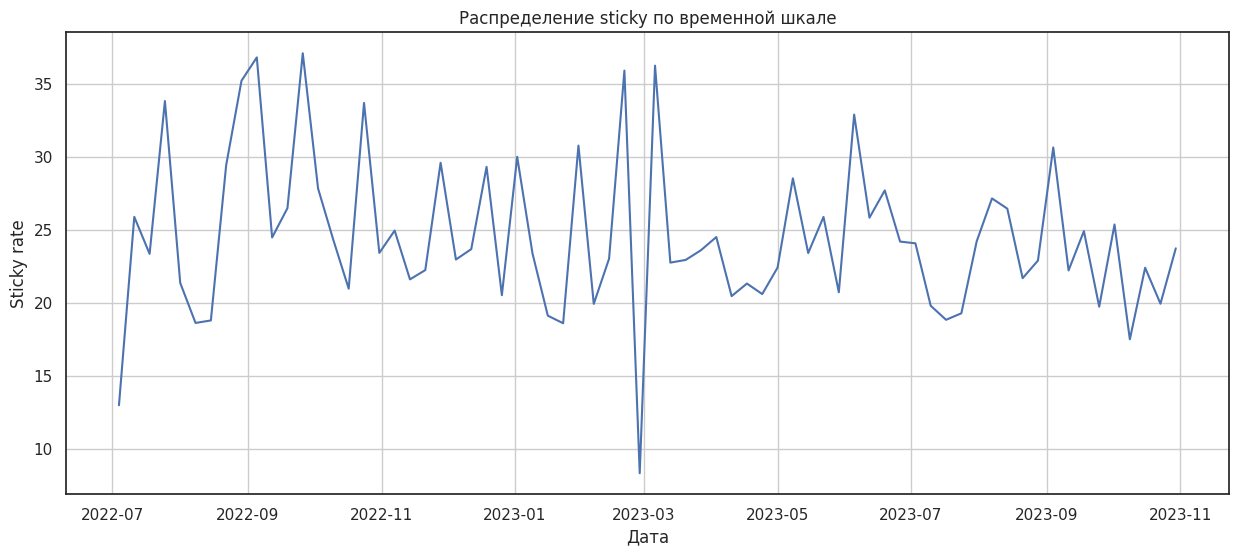

In [ ]:
fig, ax = plt.subplots(figsize=(15, 6))
ax.plot(total_visit.query('datetime > "2022-06-30" & datetime < "2023-10-30"')
.groupby([pd.Grouper(key='datetime',freq='W-Mon')])['sticky']
        .mean(), linestyle='-', color='b')
ax.set_title('Распределение sticky по временной шкале')
ax.set_xlabel('Дата')
ax.set_ylabel('Sticky rate')
ax.grid()
plt.show()


Показатель sticky плавает в интервале от 18 до 30 в течение всего времени.

### Коммерчесткие метрики

####Когортный Анализ.

***Когортный анализ*** заключается в исследовании характеристик когорт, объединенных по общим временным признакам.

Когорта — это группа, сформированная особым образом по временному признаку (в нашем случае по месяцу первой оплаты).

Для начала найдем дату первого платежа для каждого пользователя и добавим их в таблицу:

In [ ]:
cohort_table = sp
cohort_table['order_datetime'] = cohort_table['order_datetime'].astype('period[M]')
cohort_table['first_order'] = cohort_table.groupby('user_id')['order_datetime'].transform('min')
cohort_table.head()

order_id order_datetime  channel_id  \
0     37117        2021-10           1   
1     58434        2021-03           1   
3    111808        2023-03           9   
4     67535        2021-06           1   
5     72610        2021-09           1   

                                        product_name  order_price paid_status  \
0                           На уставную деятельность            1        Paid   
1                           На уставную деятельность           50        Paid   
3  Пожертвование Благотворительный фонд «АиФ. Доб...          300        Paid   
4                           На уставную деятельность          200        Paid   
5                           На уставную деятельность           25        Paid   

   user_id day_of_week                                  donation first_order  
0     2734    Thursday                 Общее пожертвование фонду     2021-03  
1     2734    Thursday                 Общее пожертвование фонду     2021-03  
3     2847   Wednesday  Пожертвование на помощь конкретному лицу     2021-06  
4     2847   Wednesday                 Общее пожертвование фонду     2021-06  
5     2861      Monday                 Общее пожертвование фонду     2021-03

Уберем из расчетов ноябрь 2023 год, т.к. он представлен только несколькими дням.

In [ ]:
cohort_table = cohort_table[cohort_table['order_datetime'] < "2023-11"]

Посмотрим количество пожертвований в каждой когорте

In [ ]:
cohort_table.groupby('first_order')['order_price'].count()

first_order
2021-01    4729
2021-02    1469
2021-03    1116
2021-04    1873
2021-05    1042
2021-06     833
2021-07     433
2021-08    1019
2021-09     961
2021-10    1073
2021-11     690
2021-12    2967
2022-01    1350
2022-02    1096
2022-03     385
2022-04    1372
2022-05    1268
2022-06    1215
2022-07    1235
2022-08    1967
2022-09    1122
2022-10     646
2022-11     563
2022-12    1488
2023-01     932
2023-02     827
2023-03     729
2023-04    1388
2023-05     672
2023-06    1184
2023-07     890
2023-08     336
2023-09    1180
2023-10     488
Freq: M, Name: order_price, dtype: int64

Вполне логично, что количество пожертвований в первой когортной группе больше, чем в последней, т.к. первая группа создана намного раньше.

Посмотрим сколько уникальных пользователей в каждой когорте

In [ ]:
cohort_group_size = cohort_table.groupby('first_order')['user_id'].nunique()
cohort_group_size.sort_values(ascending=False)

first_order
2022-08    1175
2021-12    1096
2023-09    1023
2023-04     860
2023-06     813
2022-12     708
2022-05     666
2021-04     551
2022-04     533
2023-07     522
2022-02     520
2022-09     469
2023-10     444
2022-01     429
2022-06     422
2022-07     419
2023-01     403
2023-05     361
2023-03     355
2021-01     354
2021-10     322
2021-11     297
2023-02     284
2021-05     265
2022-10     262
2021-09     249
2021-08     246
2021-06     222
2022-11     205
2021-03     200
2023-08     197
2021-02     172
2022-03     114
2021-07      66
Freq: M, Name: user_id, dtype: int64

Лидеры по количеству уникальных пользователей следующие когорты: </br>
1.  2022-08 (1175), </br>
2.  2021-12 (1096), </br>
3. 2023-09 (1023). </br>

Антилидеры
1. 2021-07 (68) </br>
2.2022-03 (114) </br>
3.2023-11 (158)



In [ ]:
# посмотрим также как изменяется количество активных (делающих пожертвования) пользоватей в когорте по месяцам.
cohort_table = cohort_table.groupby(['first_order', 'order_datetime'])['user_id'].nunique().reset_index()
cohort_table['period'] = (cohort_table.order_datetime - cohort_table.first_order).apply(attrgetter("n"))
cohort_table

first_order order_datetime  user_id  period
0       2021-01        2021-01      354       0
1       2021-01        2021-02      225       1
2       2021-01        2021-03      213       2
3       2021-01        2021-04      198       3
4       2021-01        2021-05      185       4
..          ...            ...      ...     ...
590     2023-08        2023-09       28       1
591     2023-08        2023-10       27       2
592     2023-09        2023-09     1023       0
593     2023-09        2023-10       62       1
594     2023-10        2023-10      444       0

[595 rows x 4 columns]

Сделаем сводную таблицу распределения количества пользователей делавших пожертвование по периодам внутри каждой кагорты.

In [ ]:
cohort_table_matrix = cohort_table.pivot(index='first_order', columns = 'period', values = 'user_id')#.fillna(0).astype(int)
cohort_table_matrix.head()

period          0      1      2      3      4      5      6      7      8   \
first_order                                                                  
2021-01     354.00 225.00 213.00 198.00 185.00 180.00 163.00 171.00 173.00   
2021-02     172.00  53.00  49.00  42.00  38.00  35.00  47.00  41.00  48.00   
2021-03     200.00  51.00  34.00  39.00  26.00  38.00  36.00  35.00  24.00   
2021-04     551.00  48.00  47.00  36.00  48.00  39.00  30.00  32.00  52.00   
2021-05     265.00  37.00  27.00  38.00  29.00  44.00  30.00  32.00  28.00   

period          9   ...    24    25    26    27    28    29    30    31    32  \
first_order         ...                                                         
2021-01     161.00  ... 22.00 22.00 27.00 32.00 29.00 45.00 49.00 55.00 51.00   
2021-02      34.00  ... 10.00 18.00 20.00 21.00 23.00 28.00 23.00 20.00 25.00   
2021-03      40.00  ... 11.00  6.00 13.00 25.00 19.00 21.00 22.00 24.00   NaN   
2021-04      39.00  ... 16.00 28.00 26.00 29.00 33.00 26.00 31.00   NaN   NaN   
2021-05      30.00  ... 13.00 14.00 15.00 15.00 16.00 13.00   NaN   NaN   NaN   

period         33  
first_order        
2021-01     51.00  
2021-02       NaN  
2021-03       NaN  
2021-04       NaN  
2021-05       NaN  

[5 rows x 34 columns]

Вычислим retention (процент активных клиентов в когорте от общего количества пользователей в когорте), и создадим тепловую карту.

In [ ]:
user_retention = cohort_table_matrix.divide(cohort_group_size, axis=0)
user_retention.head()

period        0    1    2    3    4    5    6    7    8    9   ...   24   25  \
first_order                                                    ...             
2021-01     1.00 0.64 0.60 0.56 0.52 0.51 0.46 0.48 0.49 0.45  ... 0.06 0.06   
2021-02     1.00 0.31 0.28 0.24 0.22 0.20 0.27 0.24 0.28 0.20  ... 0.06 0.10   
2021-03     1.00 0.26 0.17 0.20 0.13 0.19 0.18 0.17 0.12 0.20  ... 0.06 0.03   
2021-04     1.00 0.09 0.09 0.07 0.09 0.07 0.05 0.06 0.09 0.07  ... 0.03 0.05   
2021-05     1.00 0.14 0.10 0.14 0.11 0.17 0.11 0.12 0.11 0.11  ... 0.05 0.05   

period        26   27   28   29   30   31   32   33  
first_order                                          
2021-01     0.08 0.09 0.08 0.13 0.14 0.16 0.14 0.14  
2021-02     0.12 0.12 0.13 0.16 0.13 0.12 0.15  NaN  
2021-03     0.07 0.12 0.10 0.10 0.11 0.12  NaN  NaN  
2021-04     0.05 0.05 0.06 0.05 0.06  NaN  NaN  NaN  
2021-05     0.06 0.06 0.06 0.05  NaN  NaN  NaN  NaN  

[5 rows x 34 columns]

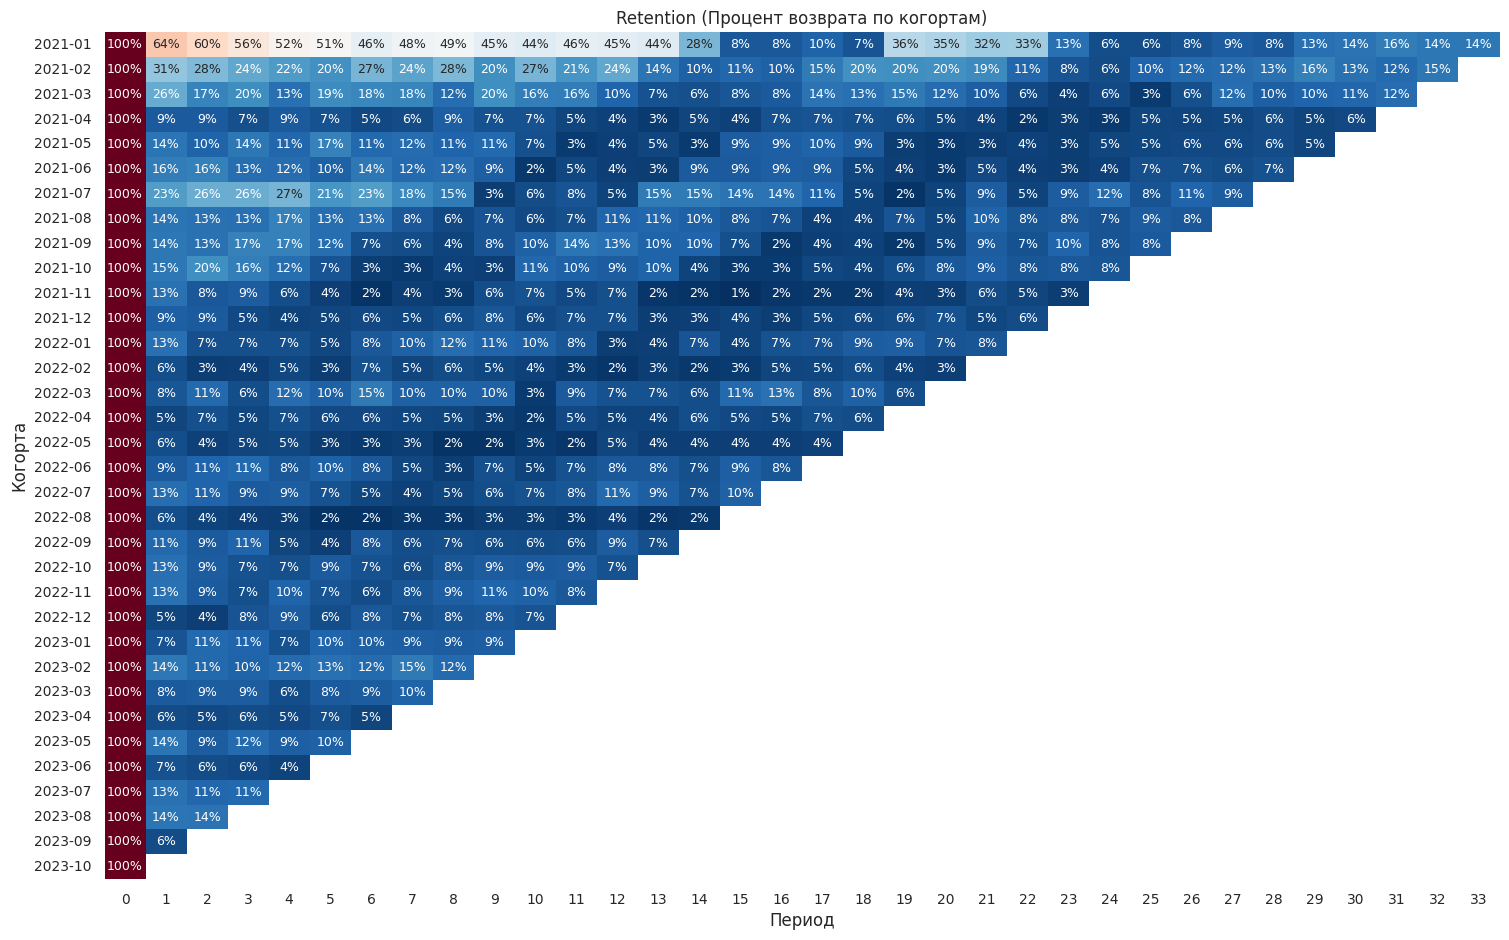

In [ ]:
sns.set(style='white')
plt.figure(figsize=(18, 11))
plt.title('Retention (Процент возврата по когортам)')
sns.heatmap(user_retention, cmap='RdBu_r', annot= True, annot_kws={'size':9}, \
            fmt='.0%', cbar=False)
plt.xticks(size = 10)
plt.yticks(size = 10)
plt.xlabel('Период', fontsize=12)
plt.ylabel('Когорта', fontsize=12)
plt.show()

По тепловой карте видно, что наиболее эффективной когортой по возврату пользователей была первая когорта (с первой оплатой в январе 2021 года).
Следующими по эффективностями стали когорты с первой оплатой в феврале и марте 2021. Но в целом после первого платежа на следующий месяц возвразается делать пожертвование не больше 30% пользователей.

##### Средний чек

Посчитаем средний чек пожертвований для всей базы.

In [ ]:
sp['order_price'].mean()

760.9506317096326

Вычислим средний чек по когортам.

In [ ]:
cohort_group_size = sp.groupby('first_order')['order_price'].mean()
cohort_group_size

first_order
2021-01    764.89
2021-02    865.34
2021-03    938.53
2021-04   1279.17
2021-05    507.24
2021-06    447.86
2021-07    768.06
2021-08    586.40
2021-09    680.87
2021-10    768.84
2021-11    611.58
2021-12    488.54
2022-01    573.38
2022-02    448.73
2022-03    807.60
2022-04    989.45
2022-05    646.11
2022-06    646.92
2022-07    697.10
2022-08    877.90
2022-09    997.73
2022-10    565.25
2022-11    506.46
2022-12    589.56
2023-01    572.05
2023-02   2198.48
2023-03    498.65
2023-04    750.95
2023-05    891.58
2023-06    746.28
2023-07    679.12
2023-08    669.10
2023-09    816.62
2023-10    935.29
2023-11   1138.97
Freq: M, Name: order_price, dtype: float64

Лидерами по среднему чеку в когорте:
1. 2023-02 (2198,48 рубл.),
2. 2021-04 (1279,17 рубл.),
3. 2023-11 (1138,97 рубл.)

Вычислим изменение среднего чека по месяцам в когортах.

In [ ]:
cohort_table = sp.groupby(['first_order', 'order_datetime'])['order_price'].mean().reset_index()
cohort_table['period'] = (cohort_table.order_datetime - cohort_table.first_order).apply(attrgetter("n"))
cohort_table.head()

first_order order_datetime  order_price  period
0     2021-01        2021-01      1040.02       0
1     2021-01        2021-02       633.46       1
2     2021-01        2021-03       604.79       2
3     2021-01        2021-04       582.70       3
4     2021-01        2021-05       644.51       4

Посколько у нас слишком много когорт и периодов (35 и 34 соответственно), визуализировать данные одним графиком не получится. Разобьем данные на 2021 и 2022-2023 года.

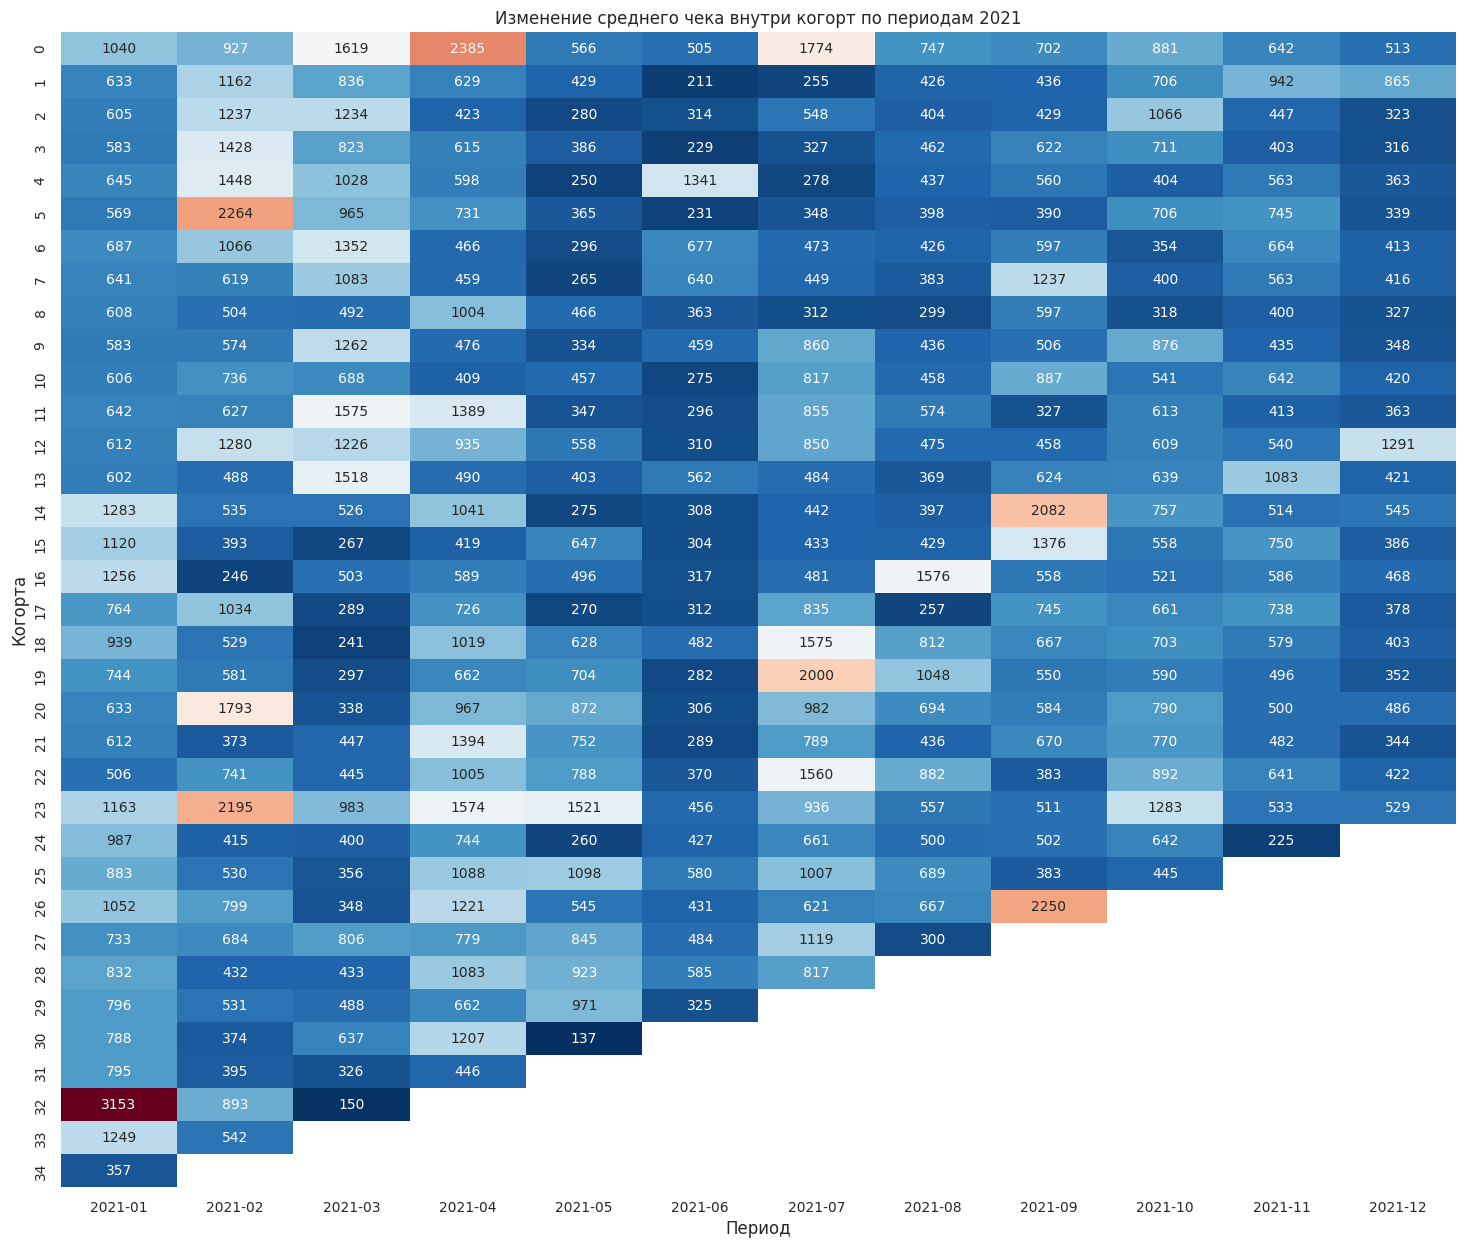

In [ ]:
sns.set(style='white')
plt.figure(figsize=(18, 15))
plt.title('Изменение среднего чека внутри когорт по периодам 2021')
sns.heatmap(cohort_table.query('first_order < "2022-01"')
.pivot(index='period', columns ='first_order', values = 'order_price'),\
            cmap='RdBu_r', annot= True, annot_kws={'size':10},\
            fmt='.0f', cbar=False)
plt.xticks(size = 10)
plt.yticks(size = 10)
plt.xlabel('Период', fontsize=12)
plt.ylabel('Когорта', fontsize=12)
plt.show()

Нет четкой динамики роста или падения среднего чека в когортах. В январской, февральской, апрельской и сентябрьской когортах за 2021 год есть 1-2 периода с высокими средними чеками (больше 2000).

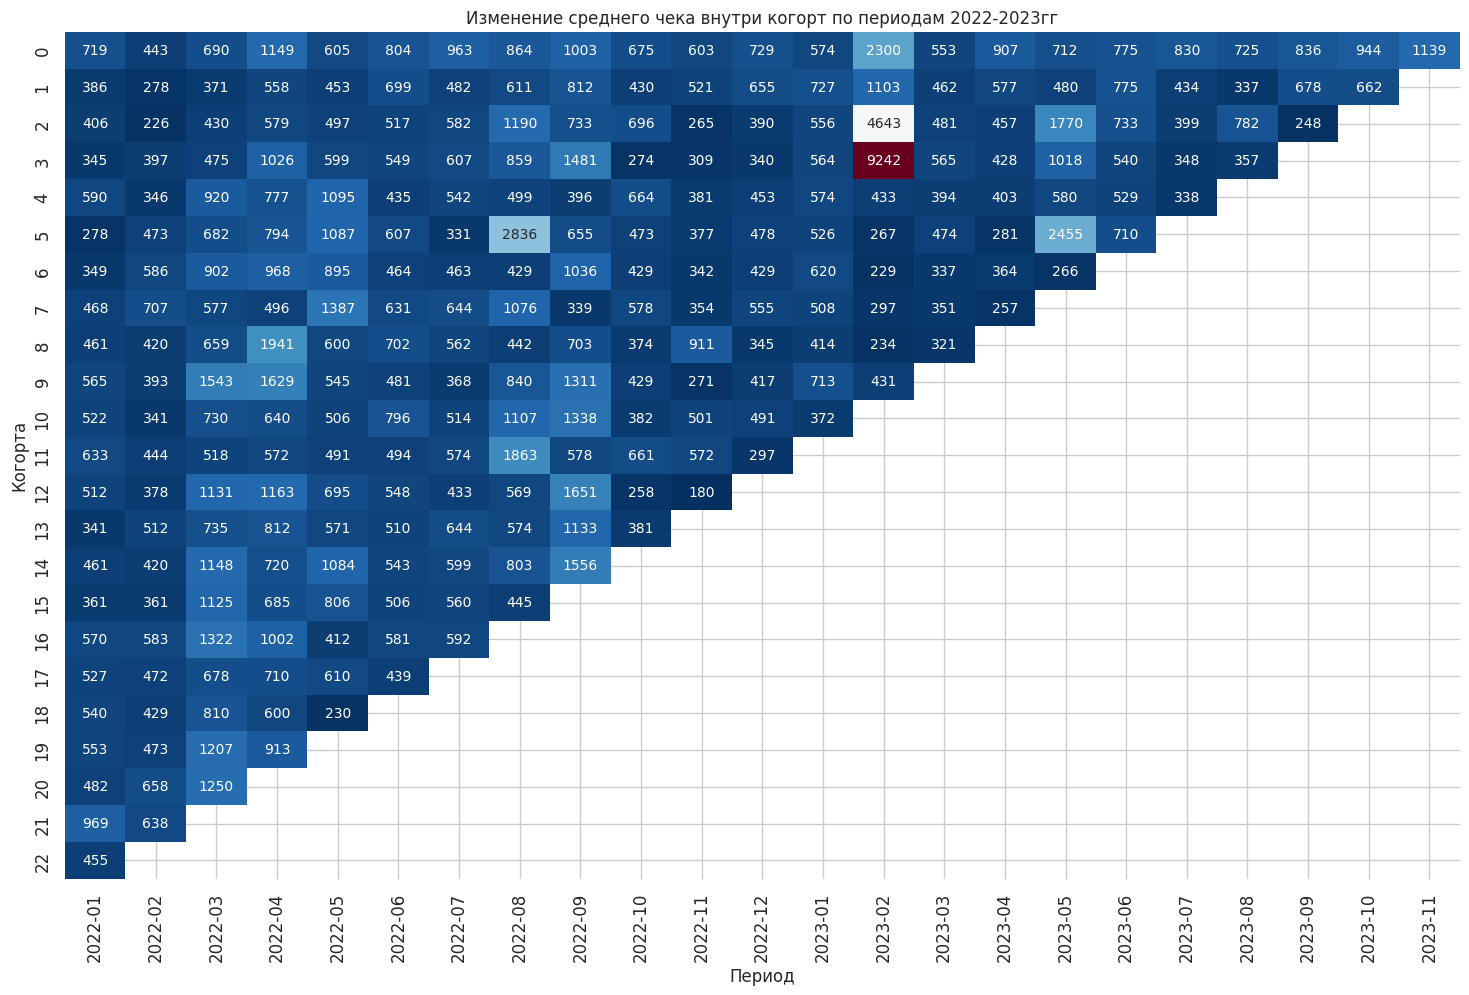

In [ ]:
sns.set(style='white')
plt.figure(figsize=(18, 11))
plt.title('Изменение среднего чека внутри когорт по периодам 2022-2023гг')
sns.heatmap(cohort_table.query('first_order > "2021-12"').pivot(index='period', columns ='first_order', values = 'order_price'),\
            cmap='RdBu_r', annot= True, annot_kws={'size':10},\
            fmt='.0f', cbar=False)
plt.xticks(size = 12)
plt.yticks(size = 12)
plt.xlabel('Период', fontsize=12)
plt.ylabel('Когорта', fontsize=12)
plt.grid()
plt.show()



В когортах 2022 и 2023 года тоже нет четкой динамики роста или падения среднего чека, однако размер среднего чека постепенно снижается. В когорт 2023-02 есть очень высокие показатели среднего чека (стоит уточнить какие могут быть причины) в апреле и мае 2023 года. Но в других когортах в это время такого роста не наблюдается.

##### Сумма платежей

Расчитаем сумму платежей по когортам.

In [ ]:
cohort_group_size = sp.groupby('first_order')['order_price'].sum()
cohort_group_size.sort_values(ascending=False) # для удобства посмотрим данные в порядке возрастания суммы платежей.

first_order
2021-01    3632462
2021-04    2406111
2023-02    1859918
2022-08    1736492
2021-12    1463173
2022-04    1364457
2021-02    1281562
2022-09    1128437
2023-04    1054333
2021-03    1049278
2023-09     979944
2023-06     898521
2022-12     889645
2022-07     869986
2021-10     831116
2022-05     825727
2022-06     797654
2022-01     779791
2021-09     655681
2023-07     618003
2023-05     603602
2021-08     599299
2023-01     540586
2021-05     530061
2022-02     495400
2023-10     471388
2021-11     424435
2021-06     375303
2022-10     369672
2023-03     368506
2021-07     334872
2022-03     313350
2022-11     288682
2023-08     234853
2023-11     186791
Freq: M, Name: order_price, dtype: int64

Лидеры по сумме оплат в когортах: </br>
1. 2021-01 (3 632 462 руб.) </br>
2. 2021-04 (2 406 111 руб.) </br>
3. 2023-02 (1 859 918 руб.)</br>

Антилидеры:
1. 2023-11 (186 791 руб.) </br>
2. 2023-08 (234 853 руб.) </br>
3. 2022-11 (288 682 руб.)</br>

Посмотрим платежи по месяцам без разбивки на когорты.

In [ ]:
sp.groupby('order_datetime')['order_price'].sum()

order_datetime
2021-01     442010
2021-02     344003
2021-03     564004
2021-04    1656569
2021-05     481870
2021-06     376019
2021-07     458235
2021-08     534541
2021-09     517620
2021-10     626837
2021-11     474520
2021-12    1118282
2022-01     781170
2022-02     655614
2022-03     456731
2022-04     903021
2022-05     626653
2022-06     626876
2022-07     804191
2022-08    1665589
2022-09    1148247
2022-10     863914
2022-11     733791
2022-12    1343944
2023-01     690711
2023-02    1111331
2023-03     839025
2023-04    1531023
2023-05    1516632
2023-06    1414930
2023-07    1371770
2023-08     967553
2023-09    1851187
2023-10    1396549
2023-11     364129
Freq: M, Name: order_price, dtype: int64

Самые большие пожертвования фонд получил:<br/>

1. 2023-09 - 1 851 187 руб.<br/>
2. 2022-08 - 1 665 589 руб.<br/>
3. 2021-04 - 1 656 569 руб.<br/>

Расчитаем сумму платежей в когортах по месяцам.

In [ ]:
cohort_table = sp.groupby(['first_order', 'order_datetime'])['order_price'].sum().reset_index()
 #поделим сумму платежей на 1000, чтобы удобнее было визуализировать данные в тысячах рублей.
cohort_table['order_price'] = cohort_table['order_price'] / 1000
cohort_table['period'] = (cohort_table.order_datetime - cohort_table.first_order).apply(attrgetter("n"))
cohort_table.head()

first_order order_datetime  order_price  period
0     2021-01        2021-01       442.01       0
1     2021-01        2021-02       167.87       1
2     2021-01        2021-03       149.38       2
3     2021-01        2021-04       136.93       3
4     2021-01        2021-05       139.22       4

С объемом данных такая же ситуация, как и со средним чеком, поэтому для изображения изменений суммы платежей внутри  когорт по месяцам разобьем данные на 2 таблицы: 2021 год и 2022-2023 гг.

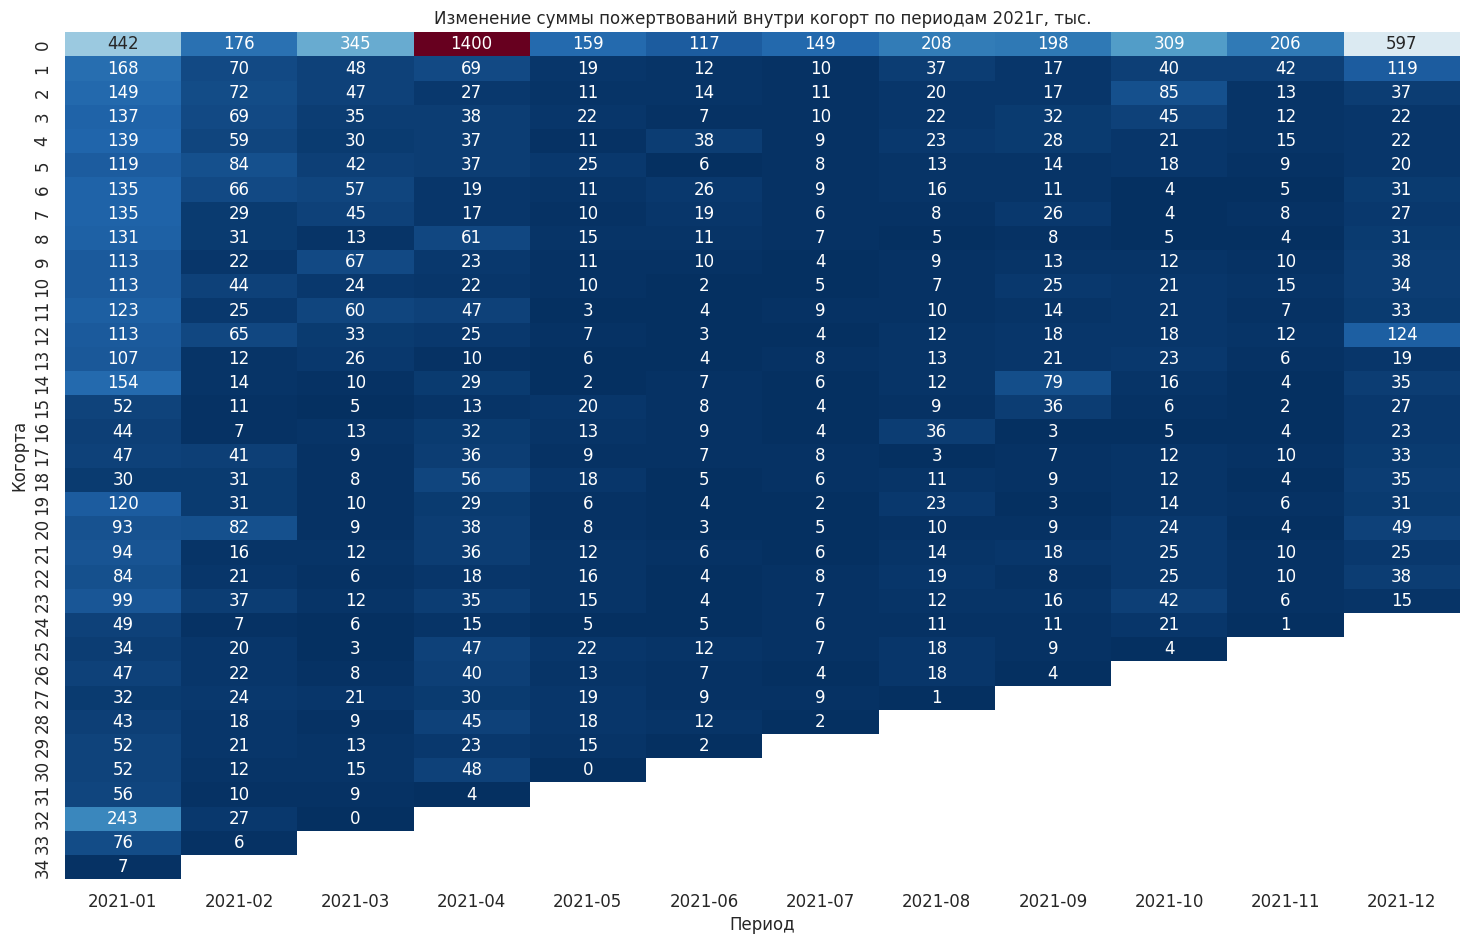

In [ ]:
sns.set(style='white')
plt.figure(figsize=(18, 11))
plt.title('Изменение суммы пожертвований внутри когорт по периодам 2021г, тыс.')
sns.heatmap(cohort_table.query('first_order < "2022-01"').pivot(index='period', columns ='first_order', values = 'order_price'),\
            cmap='RdBu_r', annot= True, annot_kws={'size':12},\
            fmt='.0f', cbar=False)
plt.xticks(size = 12)
plt.yticks(size = 12)
plt.xlabel('Период', fontsize=12)
plt.ylabel('Когорта', fontsize=12)
plt.show()

В первый месяц своего существования когорта 2021-04 принесла самую высокую сумму пожертвований в 2021 год (1 400 231 руб.) Во всех когортах (кроме 2021-12) прослеживается падение объема пожертвований на порядок на следующий месяц после первого платежа, далее уровень платежей плавающий, постепенно снижается с ростом в некоторые периоды.

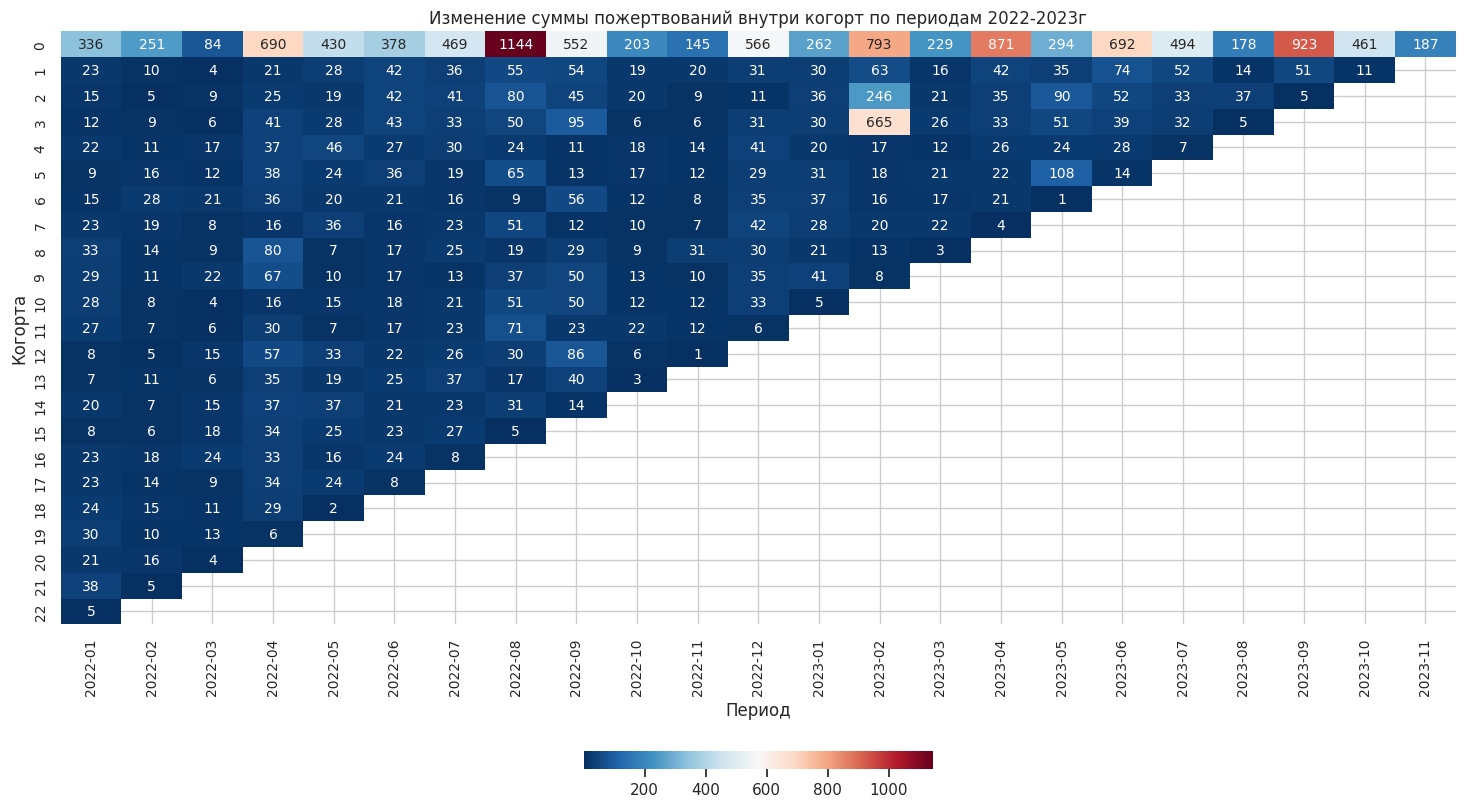

In [ ]:
sns.set(style='white')
plt.figure(figsize=(18, 11))
plt.title('Изменение суммы пожертвований внутри когорт по периодам 2022-2023г')
sns.heatmap(cohort_table.query('first_order > "2021-12"').pivot(index='period', columns ='first_order', values = 'order_price'),\
            cmap='RdBu_r', annot= True, annot_kws={'size':10},\
            fmt='.0f', cbar_kws=dict(use_gridspec=False,location="bottom",shrink=0.25))
plt.xticks(size = 10)
plt.yticks(size = 10)
plt.xlabel('Период', fontsize=12)
plt.ylabel('Когорта', fontsize=12)
plt.grid()
plt.show()

#####LTV (Lifetime Value)

LTV показывает сколько денег клиент принесёт компании за все время взаиможесткия с ней. Есть много формул, по которым можно расчитать LTV. В идеале LTV считается на основе валовой прибыли (разницы между выручкой и затратами). Но у нас нет информации о затратах на продвижение, поэтому будем считать просто по доходу. </br>

Заказчик просил посмотреть LTV по когортам.


In [ ]:
# Считаем кумулятивную (накопительную) прибыль когорты пользователей в динамике по месяцам.
cohort_cum_income = pd.pivot_table(sp, index='first_order', columns='order_datetime', values='order_price', aggfunc=sum).cumsum(axis=1)
cohort_cum_income.head()

order_datetime   2021-01   2021-02   2021-03    2021-04    2021-05    2021-06  \
first_order                                                                     
2021-01        442010.00 609878.00 759262.00  896196.00 1035411.00 1154398.00   
2021-02              NaN 176135.00 245880.00  317630.00  386175.00  445525.00   
2021-03              NaN       NaN 344875.00  392529.00  439422.00  473973.00   
2021-04              NaN       NaN       NaN 1400231.00 1468843.00 1495475.00   
2021-05              NaN       NaN       NaN        NaN  158605.00  177909.00   

order_datetime    2021-07    2021-08    2021-09    2021-10  ...    2023-02  \
first_order                                                 ...              
2021-01        1289069.00 1424362.00 1555715.00 1668324.00  ... 3024063.00   
2021-02         529275.00  595375.00  624490.00  655215.00  ... 1122727.00   
2021-03         503788.00  546241.00  603039.00  648508.00  ...  965848.00   
2021-04        1533005.00 1569508.00 1606058.00 1624708.00  ... 2118666.00   
2021-05         189380.00  211009.00  221770.00  246568.00  ...  408024.00   

order_datetime    2023-03    2023-04    2023-05    2023-06    2023-07  \
first_order                                                             
2021-01        3071385.00 3102905.00 3146173.00 3197923.00 3249915.00   
2021-02        1142350.00 1163916.00 1187844.00 1205543.00 1226785.00   
2021-03         971448.00  974648.00  982298.00 1003248.00 1012348.00   
2021-04        2153286.00 2168156.00 2214936.00 2255221.00 2285621.00   
2021-05         423794.00  439004.00  444464.00  466431.00  478961.00   

order_datetime    2023-08    2023-09    2023-10    2023-11  
first_order                                                 
2021-01        3306377.00 3549137.00 3625320.00 3632462.00  
2021-02        1238380.00 1248264.00 1275062.00 1281562.00  
2021-03        1025528.00 1040178.00 1048978.00 1049278.00  
2021-04        2331091.00 2354271.00 2402541.00 2406111.00  
2021-05         497546.00  515091.00  529651.00  530061.00  

[5 rows x 35 columns]

In [ ]:
# расчитаем LTV (т.е. вычисляем накопительную прибыль от пользователя в каждой когорте)
ltv = cohort_cum_income.divide(sp.groupby('first_order')['user_id'].nunique(), axis=0)
ltv.head()

order_datetime  2021-01  2021-02  2021-03  2021-04  2021-05  2021-06  2021-07  \
first_order                                                                     
2021-01         1248.62  1722.82  2144.81  2531.63  2924.89  3261.01  3641.44   
2021-02             NaN  1024.04  1429.53  1846.69  2245.20  2590.26  3077.18   
2021-03             NaN      NaN  1724.38  1962.64  2197.11  2369.86  2518.94   
2021-04             NaN      NaN      NaN  2541.25  2665.78  2714.11  2782.22   
2021-05             NaN      NaN      NaN      NaN   598.51   671.35   714.64   

order_datetime  2021-08  2021-09  2021-10  ...  2023-02  2023-03  2023-04  \
first_order                                ...                              
2021-01         4023.62  4394.68  4712.78  ...  8542.55  8676.23  8765.27   
2021-02         3461.48  3630.76  3809.39  ...  6527.48  6641.57  6766.95   
2021-03         2731.20  3015.20  3242.54  ...  4829.24  4857.24  4873.24   
2021-04         2848.47  2914.81  2948.65  ...  3845.13  3907.96  3934.95   
2021-05          796.26   836.87   930.45  ...  1539.71  1599.22  1656.62   

order_datetime  2023-05  2023-06  2023-07  2023-08  2023-09  2023-10  2023-11  
first_order                                                                    
2021-01         8887.49  9033.68  9180.55  9340.05 10025.81 10241.02 10261.19  
2021-02         6906.07  7008.97  7132.47  7199.88  7257.35  7413.15  7450.94  
2021-03         4911.49  5016.24  5061.74  5127.64  5200.89  5244.89  5246.39  
2021-04         4019.85  4092.96  4148.13  4230.66  4272.72  4360.33  4366.81  
2021-05         1677.22  1760.12  1807.40  1877.53  1943.74  1998.68  2000.23  

[5 rows x 35 columns]

Уже традиционно создаем тепловую карту для лучшей визуализации результатов. И традиционно делим данные на 2021 и 2022-2023 гг.

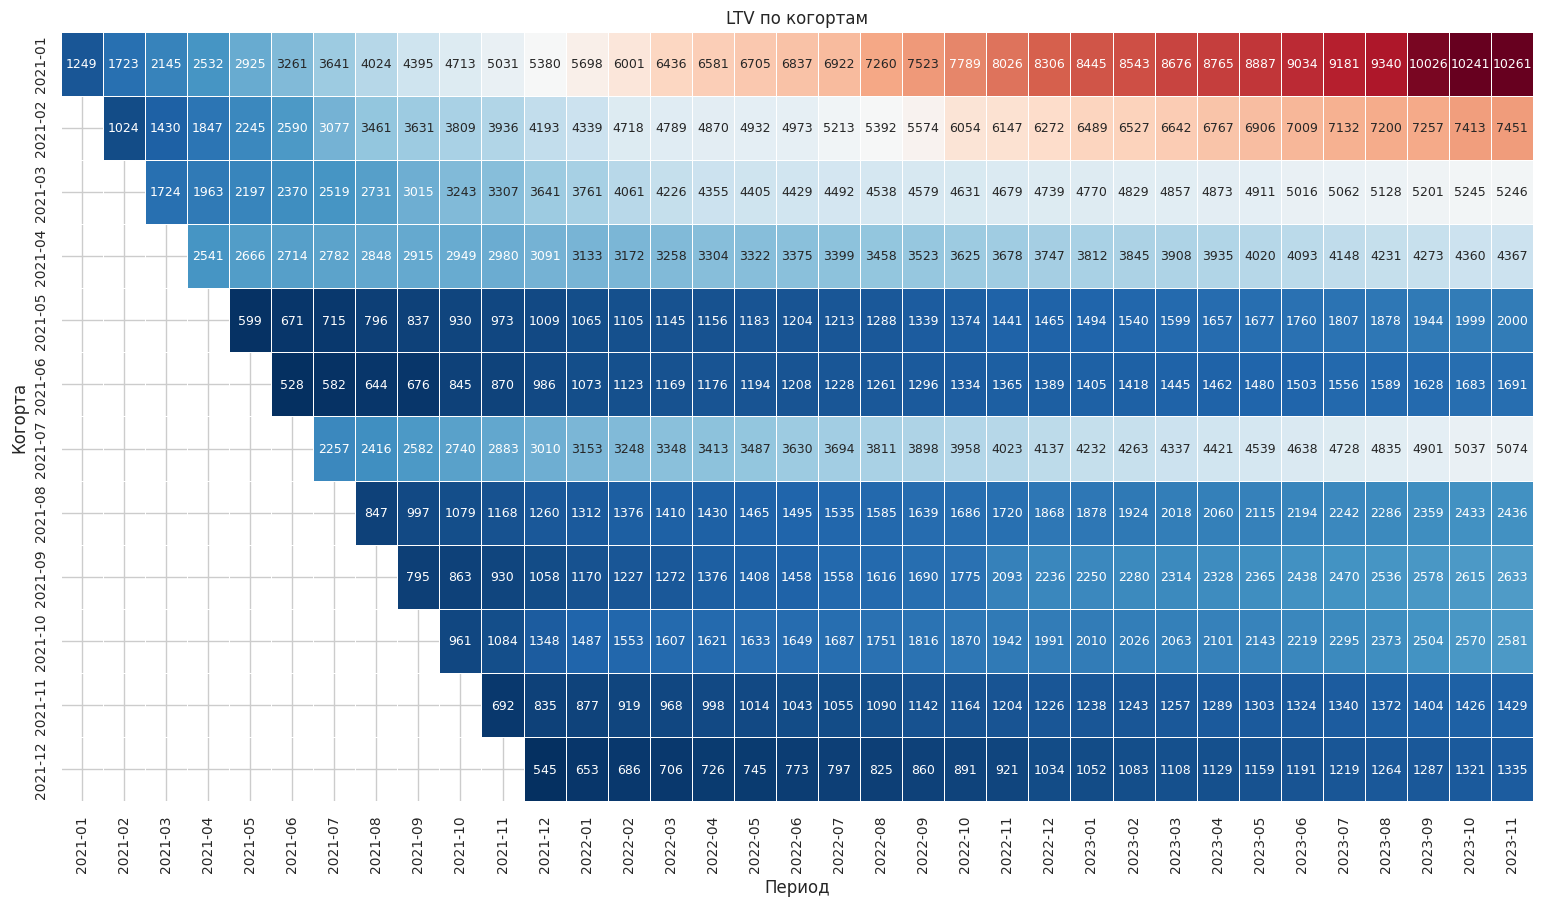

In [ ]:
sns.set(style='white')
plt.figure(figsize=(19, 10))
plt.title('LTV по когортам')
sns.heatmap(ltv.query('first_order < "2022-01"'), cmap='RdBu_r', annot= True, \
            annot_kws={'size':9}, fmt='.0f', cbar=False, linewidths = 0.7)
plt.xticks(size = 10)
plt.yticks(size = 10)
plt.xlabel('Период', fontsize=12)
plt.ylabel('Когорта', fontsize=12)
plt.grid()
plt.show()

Самый большой рост LTV произошел в первой когорте (2021-01). В этой когорте рост с 1 до последнего месяца в 8 раз. В остальных когортах рост намного меньше.

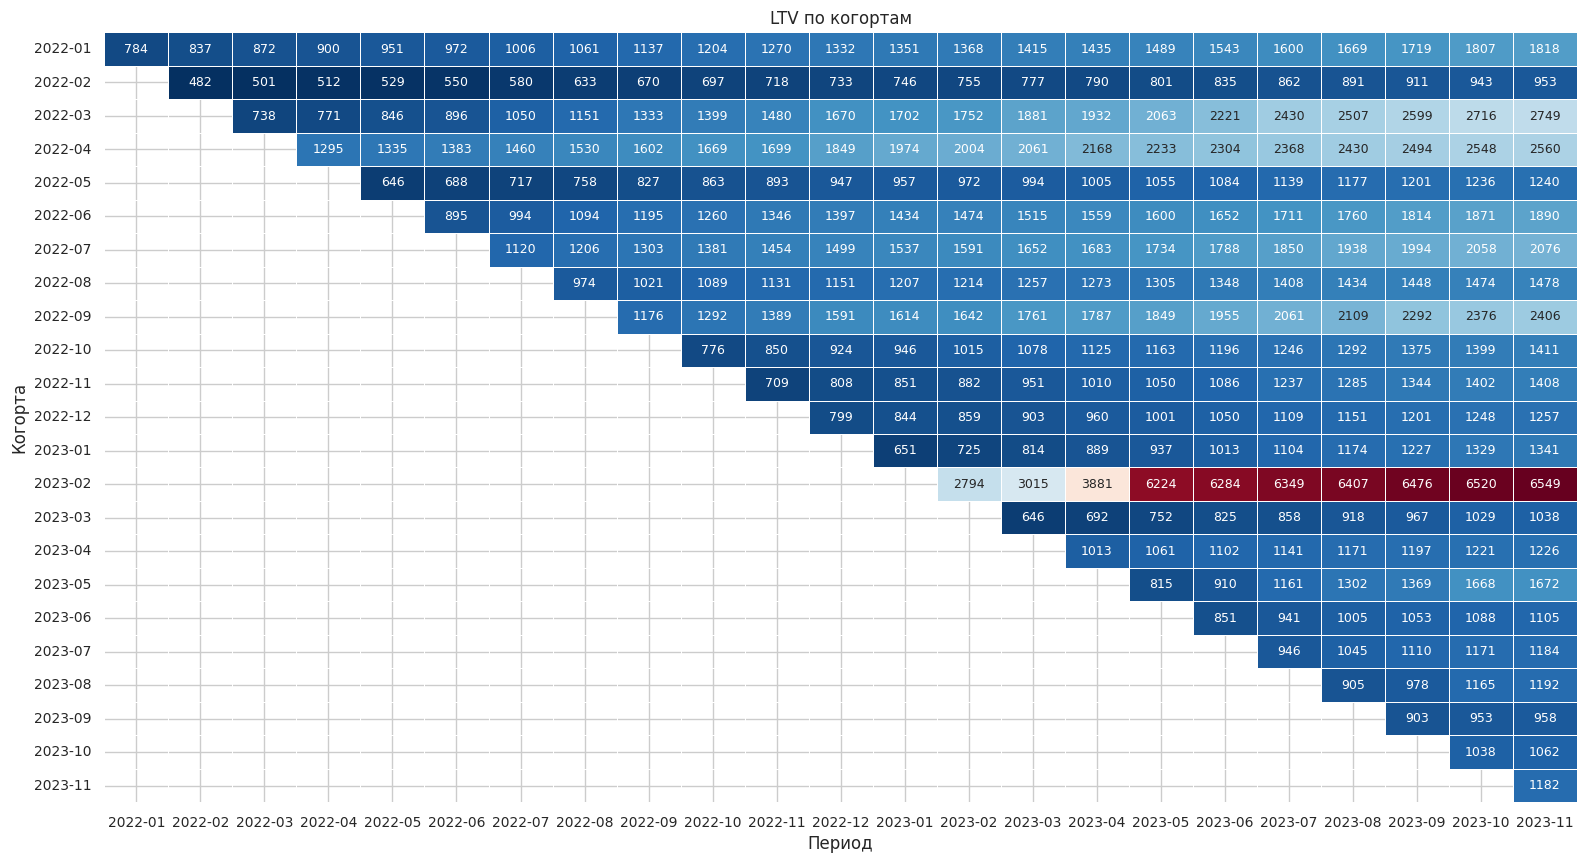

In [ ]:
ltv = ltv.drop(columns=['2021-01', '2021-02', '2021-03', '2021-04', '2021-05',\
    '2021-06', '2021-07', '2021-08', '2021-09', '2021-10', '2021-11', '2021-12'])

sns.set(style='white')
plt.figure(figsize=(19, 10))
plt.title('LTV по когортам')
sns.heatmap(ltv.query('first_order > "2021-12"'), cmap='RdBu_r', annot= True, \
            annot_kws={'size':9}, fmt='.0f', cbar=False, linewidths = 0.7)
plt.xticks(size = 10)
plt.yticks(size = 10)
plt.xlabel('Период', fontsize=12)
plt.ylabel('Когорта', fontsize=12)
plt.grid()
plt.show()

Самый большой рост LTV в когорте 2023-02, рост в 3 раза.

##Выводы
- На временных графиках видны всплески посетителей на сайте и постепеннный рост и они совпадают по времени с рассылками и платежами. Однако, это наталкивает на вывод, что у нас нет полных данных о посещении сайта всеми пользователями, а есть только тех, кто получает рассылку. Поэтому расчеты DAU, WAU, MAU и sticky считаю не точными.

- В процессе когортного анализа выделили группы по первому пожертвованию.
  - Лидером по количеству уникальных пользователей стала кагорта 2022-08 (1175), а наименьшее количество пользоваталей в когорте 2021-07 (68).
  - Наибольший показатель retention (возврат пользователей) показала первая когорта (с первой оплатой в январе 2021 года). В ней 13 месяцев уровень retention больше 40%. В остальных когортах возврат пользователей на следующий месяц после первой оплаты меньше 30%.

- Средний чек по всей базе - 760,95 рублей. Лидером по среднему чеку в стала когорта 2023-02 (2198,48 руб.), минимальный средний чек в когорте 2021-06    (447.86 руб.). В когорт 2023-02 есть очень высокие показатели среднего чека в апреле и мае 2023 года. Но в других когортах в это время такого роста не наблюдается.

- Когорта 2021-01 пожертвовала наибольшую сумму (3 632 462 руб.), а когорта 2023-08 наименьшую (234 853 руб.). В первый месяц своего существования когорта 2021-04 принесла самую высокую сумму пожертвований (1 400 231 руб.) из всех существующих когорт. Во всех когортах (кроме 2021-01) прослеживается падение объема пожертвований на порядок на следующий месяц после первого платежа.
- Самый большой рост LTV произошел в первой когорте (2021-01). В этой когорте рост с 1 до последнего месяца в 8 раз. В остальных когортах рост намного меньше.

#### RFM анализ

RFM (Recency-Frequency-Monetary) анализ — это простой метод сегментации клиентов на базе их поведения. Он группирует клиентов на основе истории их транзакций — как давно, как часто и сколько они покупали. Это удобный метод найти топовых клиентов, понять их поведение, а затем провести эффективные маркетинговые кампании. </br>
Клиентам присваиваются баллы от 1 до 3 по каждой группе (давность, частота, сумма), чем выше активность клиента, тем больше баллы. <br/>
Т.е. если клиент совершил пожертвование в недавнем прошлом, он получает более высокие баллы. Если он делал пожертвование много раз, он получает более высокий балл. А если он жертвований много денег, он получает больше баллов.

Давность будем отчитывать от следующего дня за максимальной датой пожертвования в датасете. Определим ее.

In [ ]:
sp = payments.query('paid_status == "Paid"')

last_date = sp['order_datetime'].max() + timedelta(days=1)
last_date

Timestamp('2023-11-10 00:00:00')

Посчитаем recency (давность последнего пожертвования).

In [ ]:
sp['recency'] = last_date - sp.groupby('user_id')['order_datetime'].transform('max')
sp['recency'] = sp['recency'].astype('timedelta64[D]')

Посмотрим распределение давности последнего пожертвования.

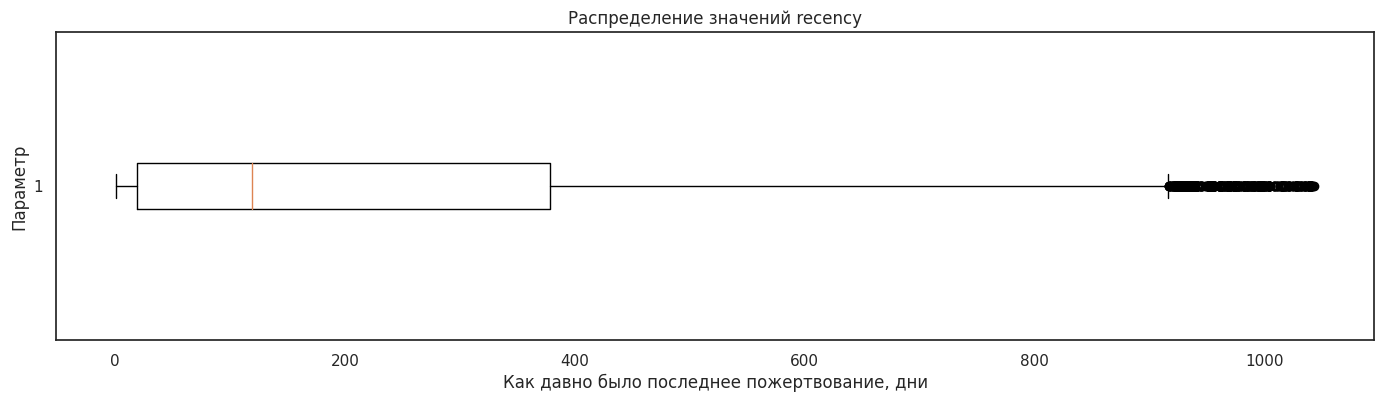

In [ ]:
fig, ax = plt.subplots(figsize=(17,4))
ax.boxplot(sp['recency'], vert=False)

plt.title('Распределение значений recency')
plt.xlabel('Как давно было последнее пожертвование, дни')
plt.ylabel('Параметр')
plt.show();

Значения давности пожертвований с выбросами, чтобы разделить данные на более равномерные группы, уберем выбросы при помощи интерквартильного размаха.

In [ ]:
# q1, q3 здесь и далее это 25 и 75 перцентили
qf_1, qf_3 = np.percentile(sp.recency, [25, 75])

In [ ]:
# интерквартильный размах это разница между 75 и 25 перцентилями
iqr_f = qf_3 - qf_1

In [ ]:
# устанавливаем верхнюю границу для выбросов: 75 перцентиль + полтора интерквартильных размаха
r_top = qf_3 + iqr_f * 1.5
r_top

916.5

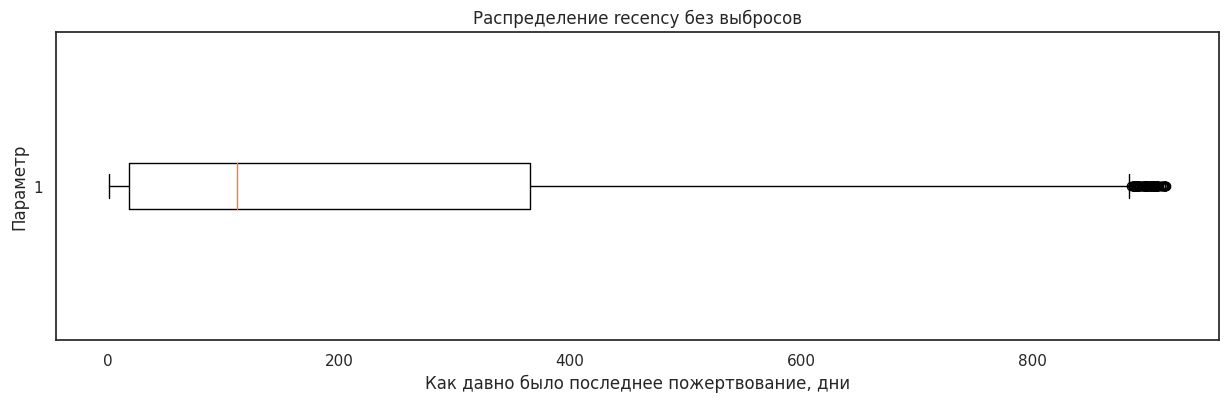

In [ ]:
fig, ax = plt.subplots(figsize=(15,4))
ax.boxplot(sp.query('recency <= @r_top')['recency'], vert=False)

plt.title('Распределение recency без выбросов')
plt.xlabel('Как давно было последнее пожертвование, дни')
plt.ylabel('Параметр')

plt.show();


разбиваем данные на 3 группы и присвоим каждому пользователю балл от 1 до 3 в зависимости от давности последнего пожертвования.

In [ ]:
pd.qcut(sp.recency, 3).unique()

[(317.0, 1043.0], (36.0, 317.0], (0.999, 36.0]]
Categories (3, interval[float64, right]): [(0.999, 36.0] < (36.0, 317.0] < (317.0, 1043.0]]

In [ ]:
r_bins = [0, 36, 317, sp.recency.max()]
# присваиваем баллы в обратном порядке, т.к. чем меньше число, тем меньше времени прошло с момента последнего пожертвования, а значит, тем ценнее пользователь.
r_labels = [3, 2, 1]

In [ ]:
sp['R'] = pd.cut(sp.recency, bins=r_bins, labels=r_labels)

Расчитаем frequency (как часто делают пожертвования).

In [ ]:
# расчитаем для каждого пользователя разнице между последней датой пожертвования и первой.
sp['period'] = sp.groupby('user_id')['order_datetime']\
    .transform(lambda cell: int((cell.max() - cell.min()) / pd.Timedelta('1d') + 1))

# определим как часто пользователи делают пожертвования, т.е. количество пожертвований разделим на период между первым и последним пожертвованием.
sp['frequency'] = sp.groupby('user_id')['order_id'].transform('count') / sp.period

Посмотрим распределение частоты пожертвований.

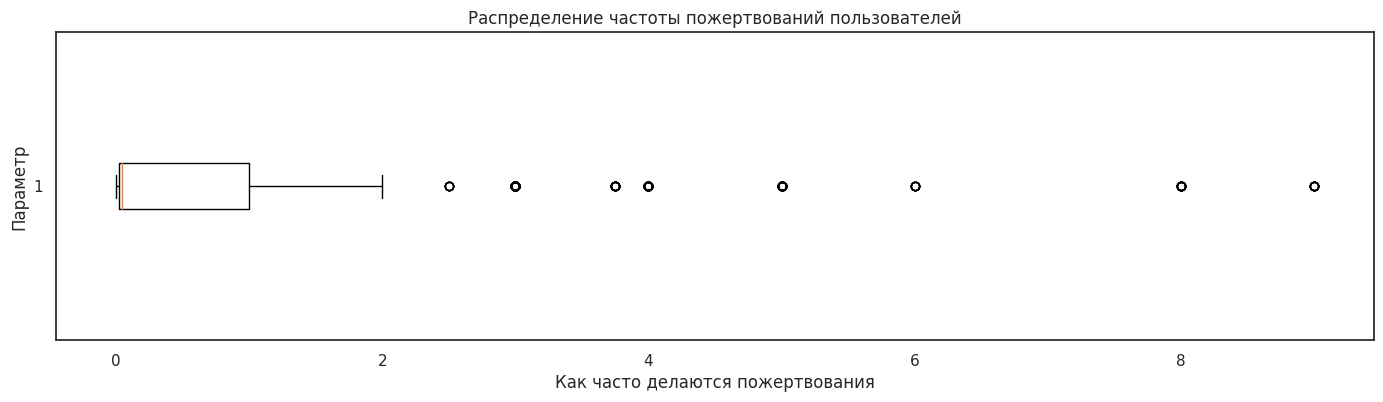

In [ ]:
fig, ax = plt.subplots(figsize=(17,4))
ax.boxplot(sp['frequency'], vert=False)

plt.title('Распределение частоты пожертвований пользователей')
plt.xlabel('Как часто делаются пожертвования')
plt.ylabel('Параметр')

plt.show();

Значения частоты пожертвований с выбросами. Очистим данные от них через интерквартильный размах, чтобы разделение на группы было более равномерным.

In [ ]:
# q1, q3 здесь и далее это 25 и 75 перцентили
qf_1, qf_3 = np.percentile(sp.frequency, [25, 75])

In [ ]:
# интерквартильный размах это разница между 75 и 25 перцентилями
iqr_f = qf_3 - qf_1

In [ ]:
# устанавливаем верхнюю границу для выбросов: 75 перцентиль + полтора интерквартильных размаха
f_top = qf_3 + iqr_f * 1.5

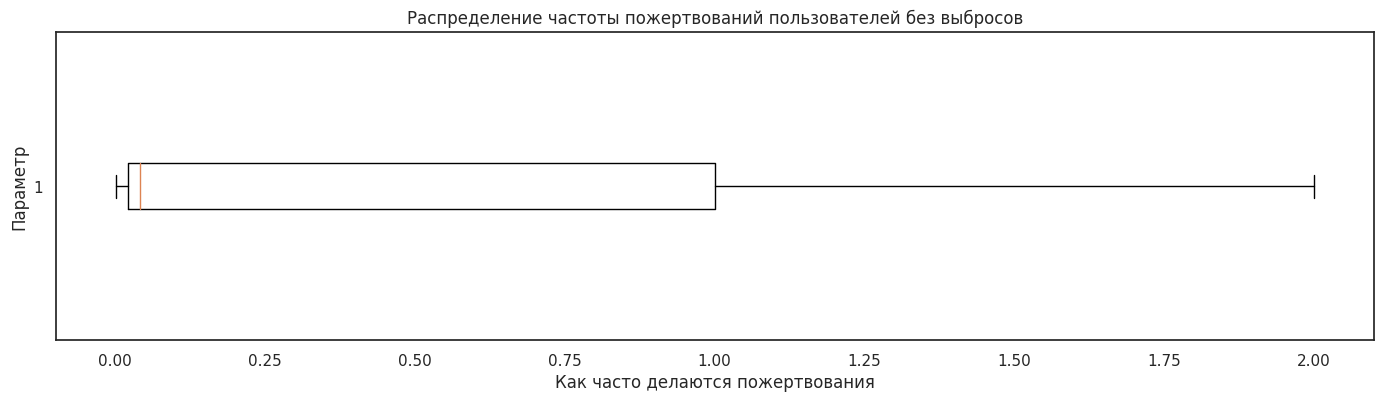

In [ ]:
fig, ax = plt.subplots(figsize=(17,4))
ax.boxplot(sp.query('frequency <=@f_top')['frequency'], vert=False)

plt.title('Распределение частоты пожертвований пользователей без выбросов')
plt.xlabel('Как часто делаются пожертвования')
plt.ylabel('Параметр')

plt.show();


Делим датасет на 3 равных интервала по показателю frequency.

In [ ]:
pd.qcut(sp.query('frequency <= @f_top').frequency, 3).unique()

[(0.001, 0.0269], (0.11, 2.0], (0.0269, 0.11]]
Categories (3, interval[float64, right]): [(0.001, 0.0269] < (0.0269, 0.11] < (0.11, 2.0]]

In [ ]:
f_bins = [0, .0269, .11, sp.frequency.max()]
f_labels = [1, 2, 3]

In [ ]:
sp['F'] = pd.cut(sp.frequency, bins=f_bins, labels=f_labels)

Расчитаем monetary (общая сумма пожертвований) для каждого пользователя.

In [ ]:
sp['monetary'] = sp.groupby('user_id')['order_price'].transform('sum')

Посмотрим как распределение значение monetary

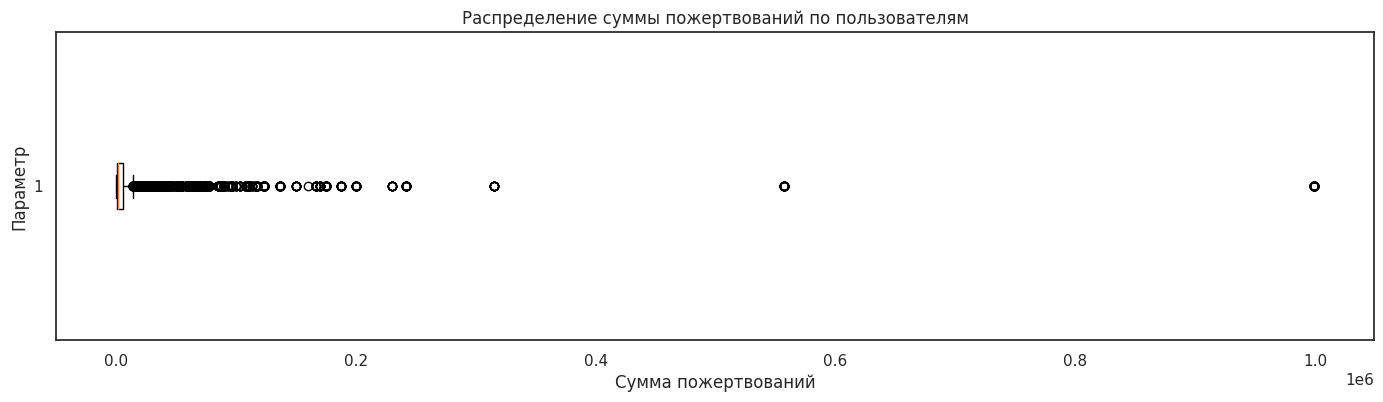

In [ ]:
fig, ax = plt.subplots(figsize=(17,4))
ax.boxplot(sp['monetary'], vert=False)

plt.title('Распределение суммы пожертвований по пользователям')
plt.xlabel('Сумма пожертвований')
plt.ylabel('Параметр')

plt.show();

Значения суммы пожертвований также с выбросами, уберем их для равномерного разбиения данных.

In [ ]:
qm_1, qm_3 = np.percentile(sp.monetary, [25, 75])

In [ ]:
iqr_m = qm_3 - qm_1

In [ ]:
m_top = qm_3 + iqr_m * 1.5

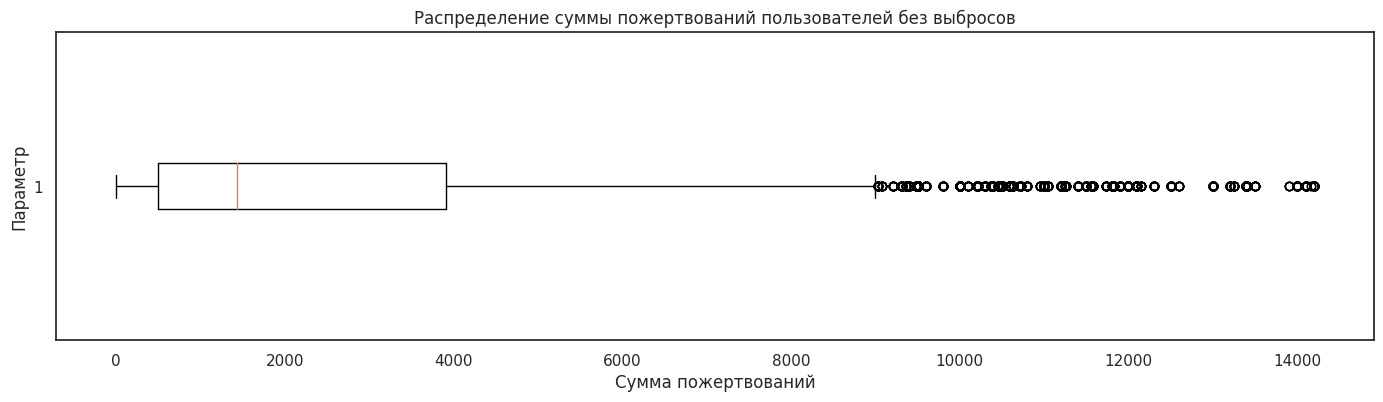

In [ ]:
fig, ax = plt.subplots(figsize=(17,4))
ax.boxplot(sp.query('monetary <=@m_top')['monetary'], vert=False)

plt.title('Распределение суммы пожертвований пользователей без выбросов')
plt.xlabel('Сумма пожертвований')
plt.ylabel('Параметр')

plt.show();

Разобем данные по значениям monetary на 3 группы и присвоим каждому пользователю балл M от 1 до 3 в зависимости от суммы пожертвований.

In [ ]:
pd.qcut(sp.query('monetary <= @m_top').monetary, 3).unique()

[(-0.001, 600.0], (2800.0, 14200.0], (600.0, 2800.0]]
Categories (3, interval[float64, right]): [(-0.001, 600.0] < (600.0, 2800.0] < (2800.0, 14200.0]]

In [ ]:
m_bins = [-0.001, 600, 2800, sp.monetary.max()]
m_labels = [1, 2, 3]

In [ ]:
sp['M'] = pd.cut(sp.monetary, bins=m_bins, labels=m_labels)

Теперь создадим столбец с единой оценкой, объединенной из трех.



In [ ]:
sp['RFM'] = sp.R.astype('str') + sp.F.astype('str') + sp.M.astype('str')

В результате получили столбцы со следующими данными:<br/>
**R (Recency — давность (как давно пользователи делали пожертвование)):** <br/>
1 - последний раз оплачивал давно (больше 317 дней), <br/>
2 - оплачивал от 36 до 317 дней назад, <br/>
3 - оплачивал недавно (не более 36 дней назад).<br/>

**F (Frequency — частота (как часто они делают пожертвования)):** <br/>
1 - регулярность платежей не часто (0.0269), <br/>
2 - средняя активность (0.0269 - 0.11), <br/>
3 - высокая активность (выше 0.11)<br/>

**M (Monetary — общая сумма пожертвований):** <br/>
1 - небольшие платежи (до 600 рублей за все время),<br/>
2 - средняя сумма платежей(600-2800 рублей),<br/>
3 - большие платежи (более 2800 рублей).Посмотрим на статистику по сегментам

In [ ]:
sp.groupby('RFM')['user_id'].nunique().sort_values(ascending=False)

RFM
131    5067
231    3136
132    1276
232     753
212     601
331     412
133     407
213     333
211     331
313     309
112     266
122     250
312     239
233     218
111     208
323     200
121     197
222     185
123     150
221     145
322     144
332     128
113     126
223     114
311      78
321      61
333      48
Name: user_id, dtype: int64

Наибольшее количество пользователей в группах:<br/>
 131 (давно часто мало) - 5067 человек, <br/>
 231 (средней давности часто мало) - 3136 человек,<br/>
 132 (давно часто средней размер платежей) - 1276 человек.

 Наименьше количество пользователей попали в группу сделавших пожертвование недавно в группах: <br/>
 311  (недавно редко мало) - 78 человек <br/>
321 (недавно среднечасто мало) - 61 человек<br/>
333 (недавно часто много)    48 человек.

In [ ]:
sp['recency'].describe()

count   41079.00
mean      234.22
std       259.63
min         1.00
25%        19.00
50%       119.00
75%       378.00
max      1043.00
Name: recency, dtype: float64

Посмотрим еще раз как распределены данные и что они говорят.

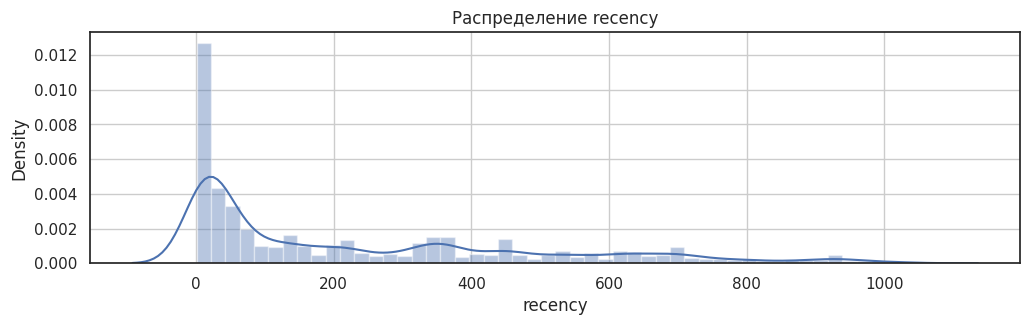

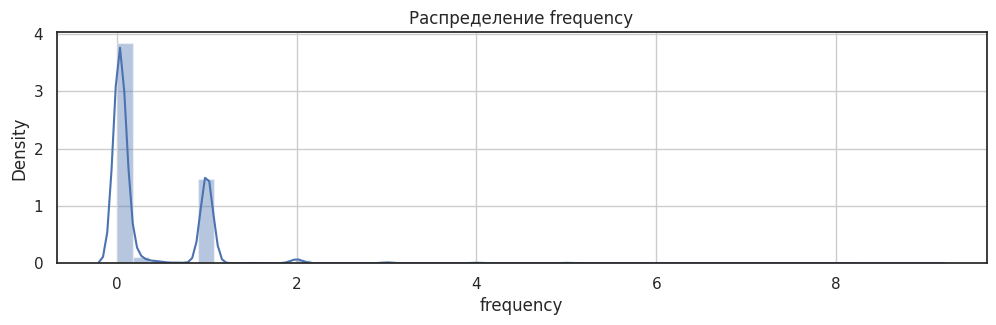

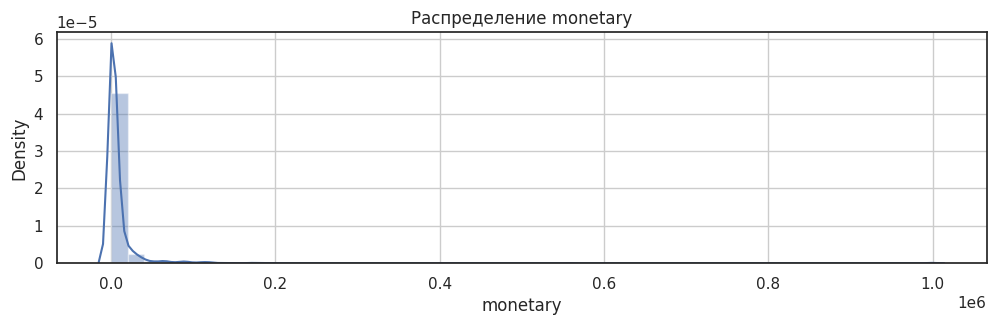

In [ ]:
col = ['recency', 'frequency', 'monetary']

for i in col:
    fig, ax = plt.subplots(figsize=(12,3))
    sns.distplot(sp[i])
    ax.set_title('Распределение %s' % i)
    ax.grid(which='both')
    plt.show()

Все распределения (по давности, частоте и сумме пожертвований) смещены влево, показывая, что большинство пользователей похожи друг на друга. И совершили пожертвование в течение 150 дней, совершают их нечасто и итоговая сумма от каждого пользователя небольшая (до 100 тыс). Очень длинный хвост в данных по давности платежей, содержит отдельных пользователей, которые сделали свое последнее пожертвование давным-давно.


Итого у нас вышло 27 сегментов. Их довольно сложно анализировать, поэтому сгруппируем некоторые категории.

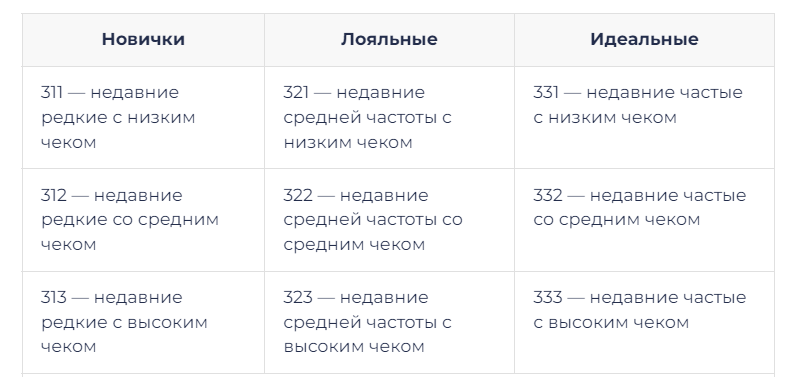
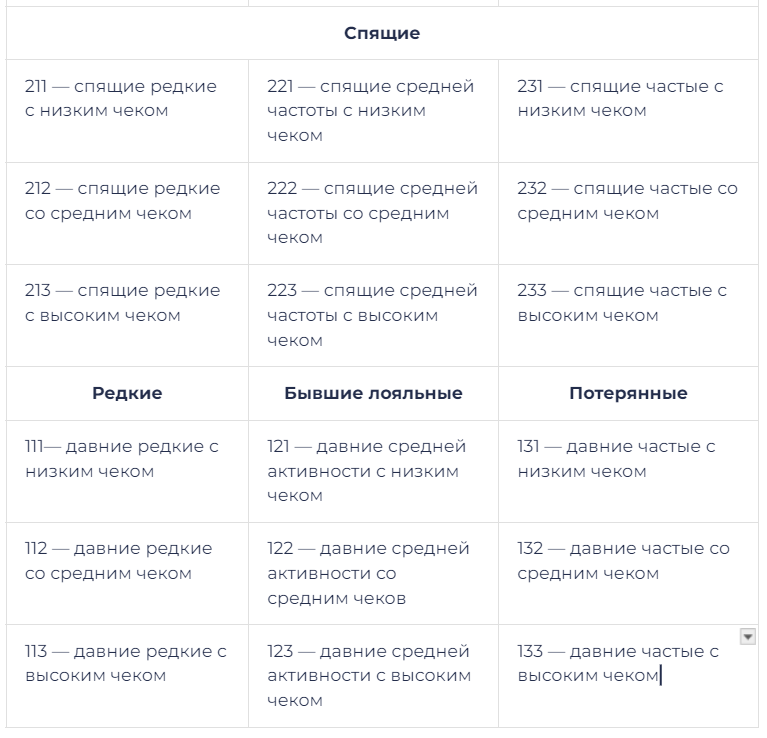

In [ ]:
# присвоим каждому пользователю категорию согласно таблице выше.
sp['RFM'] = sp['RFM'].astype('int')
def grouping(row):
  if row['RFM'] <= 113:
    return 'Редкие'
  if 123 >= row['RFM'] >= 121:
    return 'Бывшие лояльные'
  if 133 >= row['RFM'] >= 131:
    return 'Потерянные'
  if 211 <= row['RFM'] <=233:
    return 'Спящие'
  if 313 >= row['RFM'] >= 311:
    return 'Новички'
  if 323 >= row['RFM'] >= 321:
    return 'Лояльные'
  if 333 >= row['RFM'] >= 331:
    return 'Идеальные'
sp['rfm_category'] = sp.apply(grouping, axis=1)
sp['rfm_category'].unique()



array(['Редкие', 'Спящие', 'Потерянные', 'Новички', 'Бывшие лояльные',
       'Лояльные', 'Идеальные'], dtype=object)

In [ ]:
sp.groupby('rfm_category')['user_id'].nunique()

rfm_category
Бывшие лояльные     597
Идеальные           588
Лояльные            405
Новички             626
Потерянные         6750
Редкие              600
Спящие             5816
Name: user_id, dtype: int64

Самой большой группой оказались пользователи  из категории Потерянные, это 44% (6750) от всех пользователей. Следующей по размеру стала группа Спящий "Потерянная" группа - 38% (5816), дальшее идут остальные группы занимаю 3-4% от всей доли пользователей.

In [ ]:
sp.groupby('rfm_category')['order_price'].sum()

rfm_category
Бывшие лояльные     2084765
Идеальные            807335
Лояльные            4504560
Новички             3969555
Потерянные          6927771
Редкие              1939327
Спящие             11025778
Name: order_price, dtype: int64

Посмотрим распределение платежей, давности и частоты по категориям.

In [ ]:
#для начала посмотрим средние значения.
rfm_category_agg = sp.groupby('rfm_category').agg({
    'recency': ['mean'],
    'frequency':['mean'],
    'monetary':['mean','count']
}).reset_index()
rfm_category_agg.columns = ['Категории', 'Дней с последнего пожертвования, ср.', \
                            'Среднее частота пожертвований',\
                            'Средняя сумма пожертвований', 'Количество пожертвований']
rfm_category_agg

Категории  Дней с последнего пожертвования, ср.  \
0  Бывшие лояльные                                517.09   
1        Идеальные                                 12.03   
2         Лояльные                                 12.71   
3          Новички                                 16.28   
4       Потерянные                                607.13   
5           Редкие                                448.24   
6           Спящие                                134.37   

   Среднее частота пожертвований  Средняя сумма пожертвований  \
0                           0.04                      7138.85   
1                           0.50                     11559.59   
2                           0.05                     18988.69   
3                           0.02                      8675.06   
4                           1.04                      1924.84   
5                           0.02                      4955.56   
6                           0.37                     10123.01   

   Количество пожертвований  
0                      3662  
1                      1395  
2                      6586  
3                      5731  
4                      7612  
5                      2390  
6                     13703

##### **Анализ RFM-сегментов**

Посмотрим на статистику по сегментам

In [ ]:
rfm_stats = (
    sp.groupby('RFM').agg({'user_id':'nunique', 'order_price': ['count', 'mean', 'sum']}).reset_index()
)

In [ ]:
rfm_stats.columns = ['RFM сегмент', 'Человек в сегменте, чел.',
                     'Количество пожертвований', 'Среднее пожертвование, руб.',
                     'Сумма пожертвований, руб.']

In [ ]:
rfm_stats.set_index('RFM сегмент').style.format(thousands=' ', decimal=',', precision=2).bar(cmap='Pastel1')

Еще раз подтверждается наш вывод, что большинство пользователей состоят в группе, соврешавших платеж давно или среднедавно. Большую сумму платежей принесли пользователи пожертвовавшие большие единоразовые платежи.

Посмотрим какой тип пожертвований у пользователей в разных группах.

In [ ]:
rfm_channel = sp.pivot_table(index='RFM', columns='channel_id', values='order_id', aggfunc='count')
rfm_channel.columns = ['На уставную деятельность', 'Помощь конктретному лицу']
rfm_channel

На уставную деятельность  Помощь конктретному лицу
RFM                                                    
111                    287.00                    204.00
112                    677.00                    319.00
113                    778.00                    125.00
121                    470.00                    158.00
122                   1165.00                    265.00
123                   1481.00                    123.00
131                   2528.00                   2743.00
132                    735.00                    799.00
133                    490.00                    317.00
211                    127.00                    793.00
212                    601.00                   1868.00
213                    839.00                   1497.00
221                      6.00                    457.00
222                    114.00                    928.00
223                    483.00                   1154.00
231                       NaN                   3276.00
232                       NaN                    949.00
233                      2.00                    609.00
311                     30.00                    274.00
312                    473.00                   1206.00
313                   1605.00                   2143.00
321                      3.00                    343.00
322                    182.00                   1304.00
323                   1245.00                   3509.00
331                       NaN                    456.00
332                       NaN                    326.00
333                      9.00                    604.00

Посмотрим статистику рассылок по категориям.

In [ ]:
#объеденим таблицы с действиями и платежами по user_id
total_rfm = sp.merge(total_new, on="user_id")

In [ ]:
# посмотрим статистику по открытию писем.
total_rfm.query('status_sending == "MailingOpen"').groupby('rfm_category')['user_id'].count() \
/ total_rfm.query('status_sending == "MailingSend"').groupby('rfm_category')['user_id'].count()

rfm_category
Бывшие лояльные   0.13
Идеальные         0.31
Лояльные          0.62
Новички           0.36
Потерянные        0.11
Редкие            0.17
Спящие            0.26
Name: user_id, dtype: float64

Наибольший процент открытия писем в группе лояльных пользователей

In [ ]:
# посмотрим статистику по кликам писем.
total_rfm.query('status_sending == "MailingClick"').groupby('rfm_category')['user_id'].count() \
/ total_rfm.query('status_sending == "MailingOpen"').groupby('rfm_category')['user_id'].count()

rfm_category
Бывшие лояльные   0.07
Идеальные         0.25
Лояльные          0.30
Новички           0.27
Потерянные        0.06
Редкие            0.14
Спящие            0.22
Name: user_id, dtype: float64

## Выводы

В результате проведения RFM-анализа разделили пользователей на 27 группы по давности, частоте и объеме пожертвований.

- Наибольшее количество пользователей в группах: <br/>
131 (давно часто мало) - 5067 человек,<br/>
231 (средней давности часто мало) - 3136 человек,<br/>
132 (давно часто средний платеж) - 1276 человек.

- Наименьше количество пользователей попали в группу сделавших пожертвование недавно в группах:<br/>
311 (недавно редко мало) - 78 человек<br/>
321 (недавно среднечасто мало) - 61 человек<br/>
333 (недавно часто много) 48 человек.<br/>

Для более наглядного анализа объеденили группы в 6 категорий:

- Большинство пользователей похожи друг на друга. И совершили пожертвование в течение 150 дней, совершают их нечасто и итоговая сумма от каждого пользователя небольшая (до 100 тыс).

- Большинство пользователей относятся к категории потерянные (пользователи платившие давно, но часто) или спящие (пользователи делавшие пожертвование больше 36 дней назад). Лояльные и идельные клиенты составляют совместно 8% от всех пользователей. При это основной доход принесла спящая (35%) и потерянная (22%) группы пользователей. Лояльные принесли (14%), а идеальные (3%). Что подтверждает наши предыдущие выводы, что основная масса пользователей платит небольшими суммами и реже не часто.

### Маркетинговые метрики

Определим лидеров по объему пожертвований.

In [ ]:
sp.groupby('user_id')['order_price'].sum().sort_values(ascending=False).head(10)

user_id
35099    999000
35098    556600
19336    315000
18975    242000
33283    230000
25235    200000
24553    200000
19473    187523
21921    175000
32026    170000
Name: order_price, dtype: int64

Самые большой объем пожертвований от одного пользователя - 999 тыс.

Посмотрим лидеров пользователей по количеству пожертвований.

In [ ]:
sp.groupby('user_id')['order_price'].agg(['sum', 'count']).sort_values('count', ascending=False).head()

sum  count
user_id              
22683    28753    152
25737    63950    120
33202    26075    105
25797     1092     98
17488     6177     94

У фонда есть 3 пользователя, которые сделали больше 100 пожертвований.

Определим основной первый источник входа для пользователей.

In [ ]:
# исключим из данных рассылку и импорт данных.
s = total_new.query('status_sending.isna() & status_sending != "Импорт при переносе исторической базы клиентов"')
s['first_date'] = s.groupby('user_id')['datetime'].transform('min')

s.query('datetime == first_date')['channel_name'].value_counts().head(10)

Сайт                             23595
Административный сайт Mindbox     2178
utm_term Не указан                1985
Прямой переход                     744
Email                              391
vk.com                             175
yandex.ru                          147
instagram.com                      143
google.com                         125
yoomoney.ru                         44
Name: channel_name, dtype: int64

## Итоговый вывод:

В результате работы были проанализированны данные благотворительного фонда «АиФ. Доброе сердце» о пожертвованиях и активности благотворителей с 2021 по 2023 год. <br/>
Помимо изучение данных и выявления закономерностей и зависимостей, а также расчета различных маркетинговых показателей были проведены RFM и когортный анализ благотворителей, расчтитаны retention, LTV, средний чек. <br/>

Подробные выводы по каждому этапу работ можно найти в конце каждого раздела. Здесь отметим лишь самое важное:
- email база фонда довольно живая, 64% уникальных пользователя открывают рассылку. Из них 31% кликает на ссылки и переходит на сайт.
- прослеживается четкая зависимость роста посещаемости сайта и платежей от рассылок.
- большая часть благотворителей совершает небольшие пожертвования (до 1000 руб.), и сумма платежей на временной шкале не растет.
- 62% пользователей совершили пожертвование только один раз.
- с апреля 2022 год появилась проблема с прохождением платежей, стоит разобраться в причине этого, т.к. в неоплаченных платежа большие разовые платежи.
- наилучшие результаты по retention, объемам пожертвований и росту LTV показала первая когорта (с первой оплатой в январе 2021 года). В ней 13 месяцев уровень retention был больше 40%, а рост LTV с 1 до последнего периода в 8 раз. В остальных когортах результаты намного ниже.
- RFM-анализ показал, что наибольшее количество благотворителей находится в группе 131 (давно часто мало / 5067 человек), а наименьшее в 333 (недавно часто много / 48 человек).
- большинство пользователей похожи друг на друга. Они совершили пожертвование в течение 150 дней, совершают их нечасто и итоговая сумма от каждого пользователя небольшая (до 100 тыс).

